<a href="https://colab.research.google.com/github/vikram2727/Volve-ML/blob/main/K1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all the libraries required for this chapter
# Machine Learning Libraries: scikit-learn, keras and tensorflow

# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize, Normalizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.compose import ColumnTransformer
import sklearn.cluster as cluster
import lightgbm as lgb
import xgboost as xgb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.utils import np_utils

# plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  # visualization
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.offsetbox import AnchoredText
# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)
plt.style.use("seaborn-white")
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone  https://github.com/vikram2727/o-g_data_analsis
!pip install lasio
import lasio

fatal: destination path 'o-g_data_analsis' already exists and is not an empty directory.


# Step 1. Load and Display the Well-log Datasets

In [ ]:
import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join("/content/o-g_data_analsis/well_logs", "*.las")))

well_df = [0] * 3

for i in range(len(paths)):
  # read with lasio
  well = lasio.read(paths[i])

  # convert to dataframe
  df = well.df()

  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = df.reset_index()

well1, well2, well3 = well_df

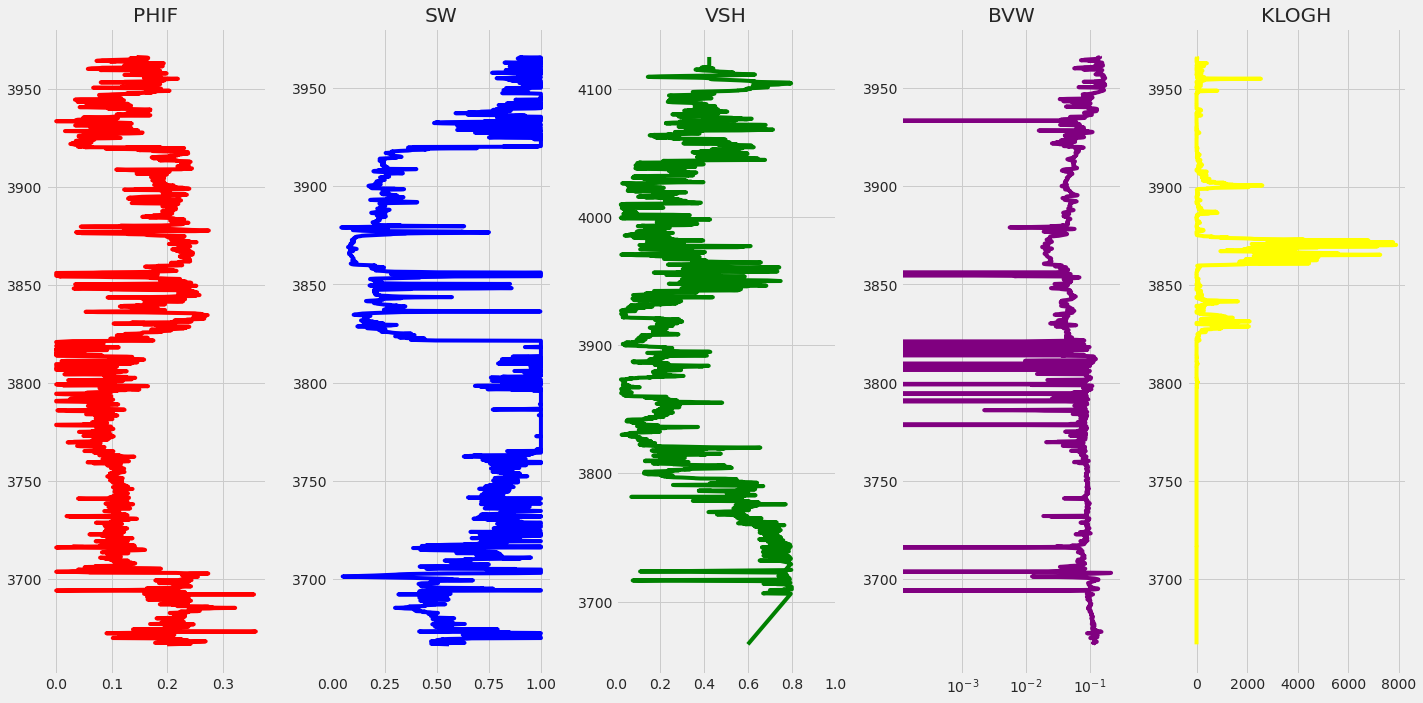

In [ ]:
plt.style.use('fivethirtyeight')
# Display train well data
well = well1 # train wells: well1, well3, well4

# define what logs are we going to us
logs = ['PHIF','SW','VSH','BVW','KLOGH']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['red', 'blue', 'green', 'purple','yellow']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 1)
#ax[4].set_xlim(0, 1000)
#ax[].set_xlim(0, 1000)
plt.tight_layout(1.1)
plt.show()

In [ ]:
well3.info(verbose = False, buf=None, max_cols=None, memory_usage=None, null_counts=None)
well3.rename(columns = {'BWV':'BVW'}, inplace = True) 
well3.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7013 entries, 0 to 7012
Columns: 9 entries, DEPTH to VSH
dtypes: float64(9)
memory usage: 493.2 KB


DEPTH     BVW      DT     KLOGH  ...    PHIF  SAND_FLAG      SW     VSH
count 7013.00 7012.00 7012.00   6782.00  ... 6886.00    6886.00 6886.00 1882.00
mean  4084.02    0.10   93.88   1848.90  ...    0.11       0.27    0.96    0.39
std    308.55    0.09  101.85  16633.80  ...    0.10       0.44    0.13    0.31
min   3549.70    0.00   13.09      0.00  ...    0.00       0.00    0.08   -0.25
25%   3816.86    0.02   66.30      0.00  ...    0.02       0.00    1.00    0.24
50%   4084.02    0.09   75.07      0.01  ...    0.09       0.00    1.00    0.34
75%   4351.17    0.16   94.73      3.80  ...    0.19       1.00    1.00    0.45
max   4618.33    0.35 1019.10 760405.25  ...    0.35       1.00    1.00    2.46

[8 rows x 9 columns]

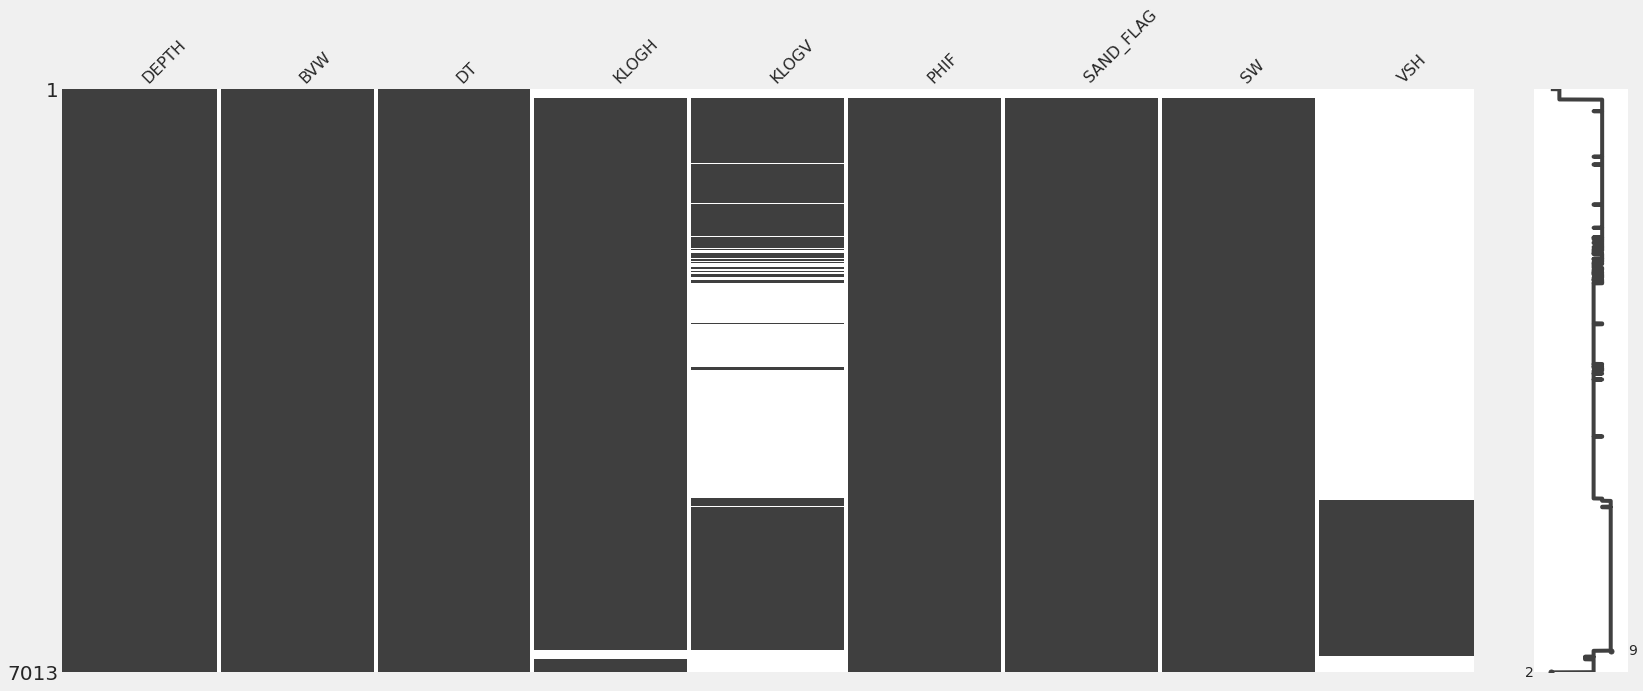

In [ ]:
import missingno as msno
msno.matrix(well3)

In [ ]:
avg = well3['KLOGV'].mean()
well3['KLOGV'].fillna(value = avg ,  inplace=True)
avg = well3['KLOGH'].mean()
well3['KLOGH'].fillna(value = avg ,  inplace=True)

avg = well3['PHIF'].mean()
well3['PHIF'].fillna(value = avg ,  inplace=True)

avg = well3['SW'].mean()
well3['SW'].fillna(value = avg ,  inplace=True)

avg = well3['SAND_FLAG'].mean()
well3['SAND_FLAG'].fillna(value = avg ,  inplace=True)

avg = well3['BVW'].mean()
well3['BVW'].fillna(value = avg ,  inplace=True)

avg = well3['VSH'].mean()
well3['VSH'].fillna(value = avg ,  inplace=True)

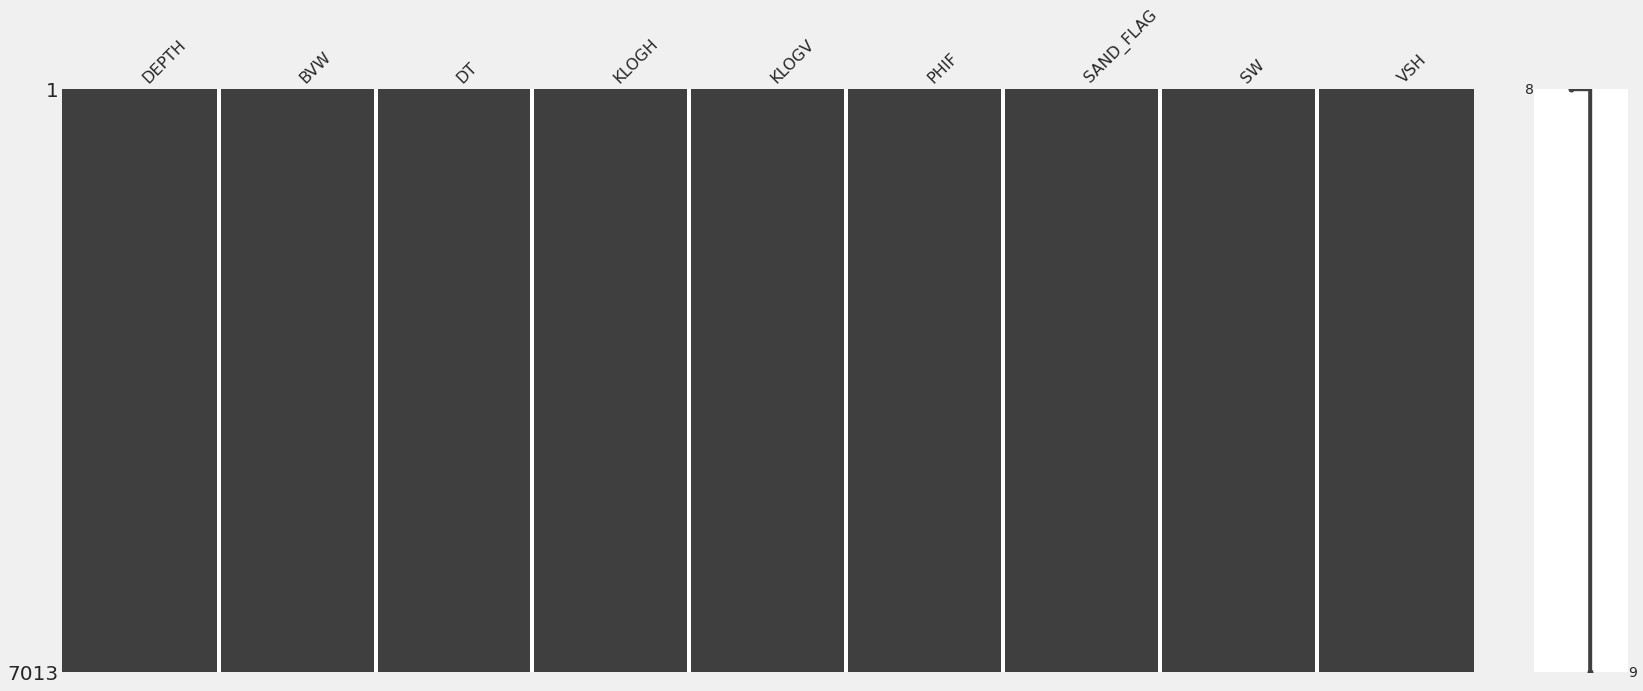

In [ ]:
msno.matrix(well3)

# Step 2. Data Preparation

In [ ]:
# lower limit
low = [3825,4040,3700]

# upper limit
up = [3920,4180,3800]

# train columns to use
train_cols = ['DEPTH','PHIF','SW','VSH','BVW', 'KLOGH', 'KLOGV']

# test columns to use
test_cols = ['DEPTH','PHIF','SW','VSH','BVW', 'KLOGH']

well_df_restrict = [0] * 3

for i in range(len(well_df)):
  # restrict depth within the given lower and upper limit
  df = well_df[i].loc[(well_df[i]['DEPTH'] >= low[i]) & (well_df[i]['DEPTH'] <= up[i])]

  if i == 1 or i == 2:
    # the train data, drop unwanted columns
    well_df_restrict[i] = df[train_cols]
  
  else:
    # the test data, drop unwanted columns
    well_df_restrict[i] = df[test_cols]

well1, well2, well3 = well_df_restrict

# as we can see, both ends already not have NaNs
well1.describe()

DEPTH   PHIF     SW    VSH    BVW   KLOGH
count  623.00 623.00 623.00 623.00 623.00  623.00
mean  3872.48   0.19   0.25   0.16   0.04  754.72
std     27.43   0.05   0.14   0.09   0.01 1448.17
min   3825.09   0.00   0.04   0.02   0.00    0.10
25%   3848.79   0.17   0.18   0.09   0.03   29.19
50%   3872.48   0.21   0.23   0.17   0.04  111.23
75%   3896.18   0.23   0.27   0.22   0.05  650.68
max   3919.88   0.28   1.00   0.48   0.08 7899.63

In [ ]:
# merge dataframes
well_train = pd.concat([well2, well3])
well_pred = pd.concat([well1])

# assign names
names = ['15_9-19 A', '15_9-19 BT2', '15_9-19 SR']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
  if i == 1 or i == 2 :
    # train data, assign names 
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_train.append(_)
  else:
    # test data, assign names
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred



well_train.describe()

PHIF      SW     VSH     BVW     KLOGH     KLOGV   DEPTH
count 1574.00 1574.00 1574.00 1574.00   1574.00   1574.00 1574.00
mean     0.23    0.96    0.28    0.22   6266.07   6920.25 3959.97
std      0.06    0.11    0.15    0.06  22411.54  26400.29  181.15
min      0.00    0.12    0.02    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19     12.76     16.09 3760.05
50%      0.22    1.00    0.37    0.22    484.61    418.72 4060.01
75%      0.28    1.00    0.39    0.27   1699.70   1552.85 4119.94
max      0.35    1.00    0.94    0.35 238779.50 290363.47 4179.87

In [ ]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [ ]:
well_pred.describe()

PHIF     SW    VSH    BVW   KLOGH   DEPTH
count 623.00 623.00 623.00 623.00  623.00  623.00
mean    0.19   0.25   0.16   0.04  754.72 3872.48
std     0.05   0.14   0.09   0.01 1448.17   27.43
min     0.00   0.04   0.02   0.00    0.10 3825.09
25%     0.17   0.18   0.09   0.03   29.19 3848.79
50%     0.21   0.23   0.17   0.04  111.23 3872.48
75%     0.23   0.27   0.22   0.05  650.68 3896.18
max     0.28   1.00   0.48   0.08 7899.63 3919.88

In [ ]:
#well_train.to_csv('/content/sample_data.csv', index=False)

#well_pred.to_csv('/content/sample1.csv', index=False)


In [ ]:
#well_train = pd.read_excel('/content/o-g_data_analsis/well_train.xlsx')
#well_pred = pd.read_csv('/content/o-g_data_analsis/well log/sample.csv')

In [ ]:
well_train.insert(4,'HMR', well_train['KLOGH'].values/well_train['PHIF'].values,True)

In [ ]:
well_train.describe()

PHIF      SW     VSH     BVW     HMR     KLOGH     KLOGV   DEPTH
count 1574.00 1574.00 1574.00 1574.00 1567.00   1574.00   1574.00 1574.00
mean     0.23    0.96    0.28    0.22     inf   6266.07   6920.25 3959.97
std      0.06    0.11    0.15    0.06     nan  22411.54  26400.29  181.15
min      0.00    0.12    0.02    0.00    0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19   74.87     12.76     16.09 3760.05
50%      0.22    1.00    0.37    0.22 2282.70    484.61    418.72 4060.01
75%      0.28    1.00    0.39    0.27 7485.87   1699.70   1552.85 4119.94
max      0.35    1.00    0.94    0.35     inf 238779.50 290363.47 4179.87

In [ ]:
# Replacing infinite with nan
well_train.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
well_train.dropna(inplace=True)
  
# Printing df
well_train.describe()

PHIF      SW     VSH     BVW       HMR     KLOGH     KLOGV   DEPTH
count 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22  19878.75   6322.31   6982.28 3958.34
std      0.06    0.11    0.14    0.06  66315.69  22504.04  26510.40  181.07
min      0.00    0.12    0.02    0.00      0.00      0.00      0.00 3700.12
25%      0.20    0.96    0.12    0.19     71.68     15.77     17.44 3759.52
50%      0.22    1.00    0.37    0.22   2245.48    490.73    434.60 4058.95
75%      0.28    1.00    0.39    0.27   7346.22   1700.08   1588.87 4119.11
max      0.35    1.00    0.90    0.35 689960.62 238779.50 290363.47 4179.72

In [ ]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [ ]:
data = {'Logs': ['PHIF',	'SW',	'VSH',	'BVW','HMR','KLOGH',	'KLOGV'],
        'std' : [0.06,	0.14,	0.25,	0.06,	3283.98,	770.44,	731.76	],
        'mean': [0.18,	0.94,	0.27,	0.17,	1891.68,	398.05,	354.42	]}
variance_df = pd.DataFrame(data)

variance_df.insert(3,'variance', variance_df['std'].values/variance_df['mean'].values,True)
variance_df

Logs     std    mean  variance
0   PHIF    0.06    0.18      0.33
1     SW    0.14    0.94      0.15
2    VSH    0.25    0.27      0.93
3    BVW    0.06    0.17      0.35
4    HMR 3283.98 1891.68      1.74
5  KLOGH  770.44  398.05      1.94
6  KLOGV  731.76  354.42      2.06

In [ ]:
px.box(well_train, x='KLOGV', orientation='h', points='all')

In [ ]:
px.box(well_train, x='KLOGH', orientation='h', points='all')

In [ ]:
px.box(well_train, x='HMR', orientation='h', points='all')

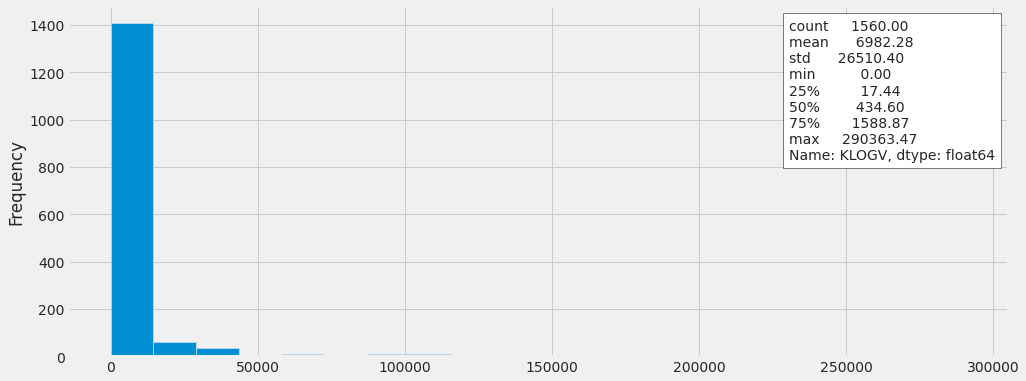

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train['KLOGV'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['KLOGV'].describe()), loc=1)
ax.add_artist(anchored_text)

## here we can se high degree of variance((std/mean) is high) we need to go for smoothing technique
## after smoothing we can go for normalization fro more better distribution

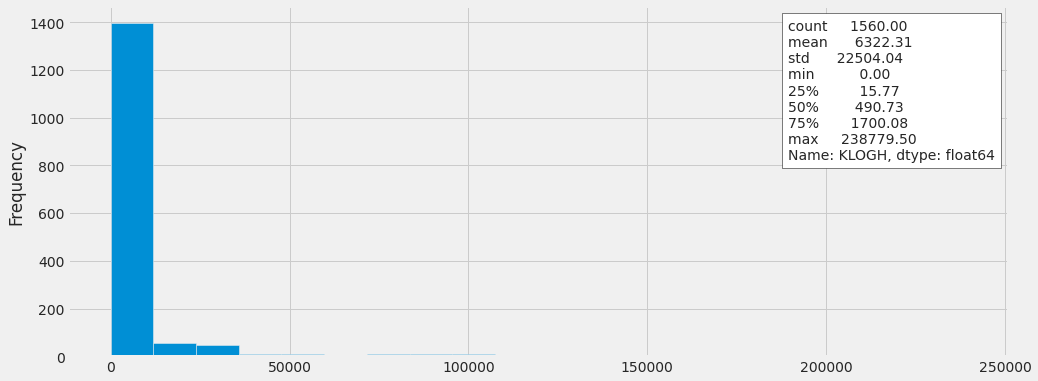

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train['KLOGH'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['KLOGH'].describe()), loc=1)
ax.add_artist(anchored_text)

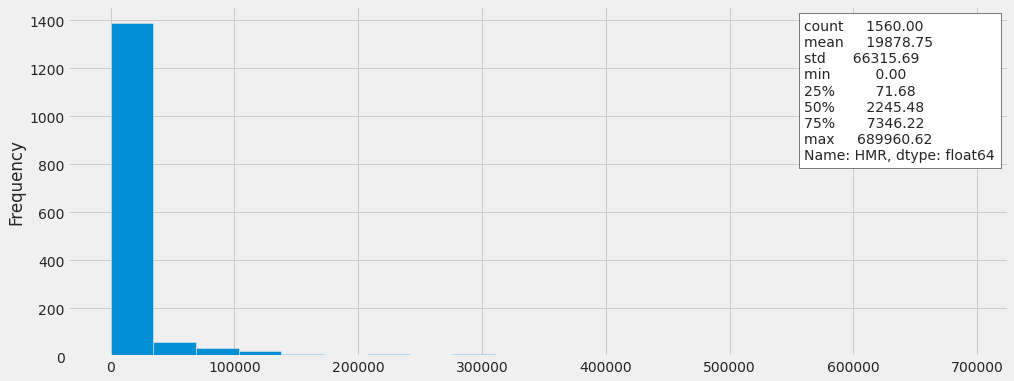

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train['HMR'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train['HMR'].describe()), loc=1)
ax.add_artist(anchored_text)

# Step 3. Smoothing High Variance Data

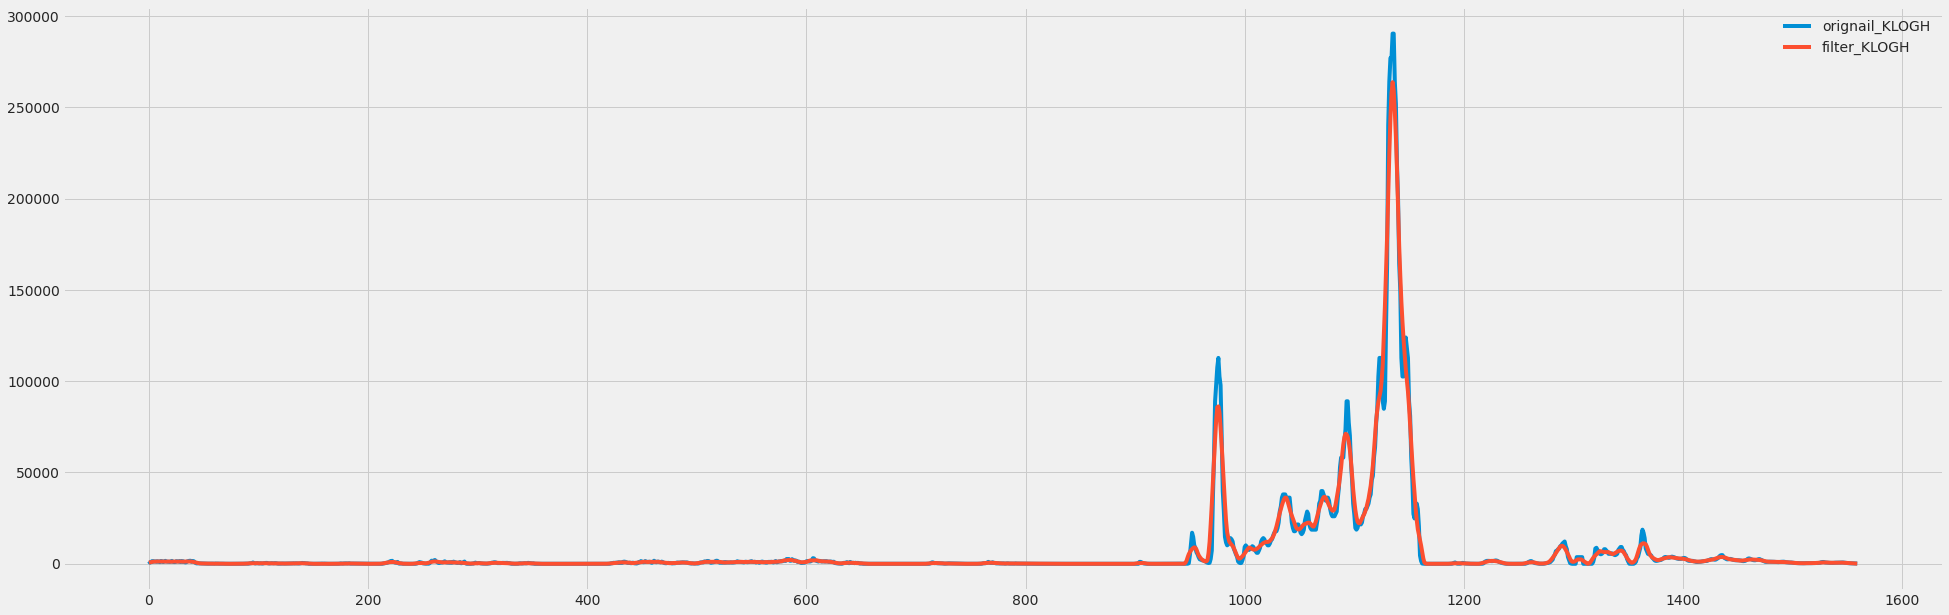

In [ ]:
## smoothing vertical permeability 
p = well_train['KLOGV'].values
filter_length = 9
tair_moving_avg = np.convolve(p,np.ones((filter_length)),mode = 'same')
tair_moving_avg /= filter_length

plt.figure(figsize = (30,10))
plt.plot(p, label = 'orignail_KLOGH')
plt.plot(tair_moving_avg, label = 'filter_KLOGH')
plt.legend()
plt.show()

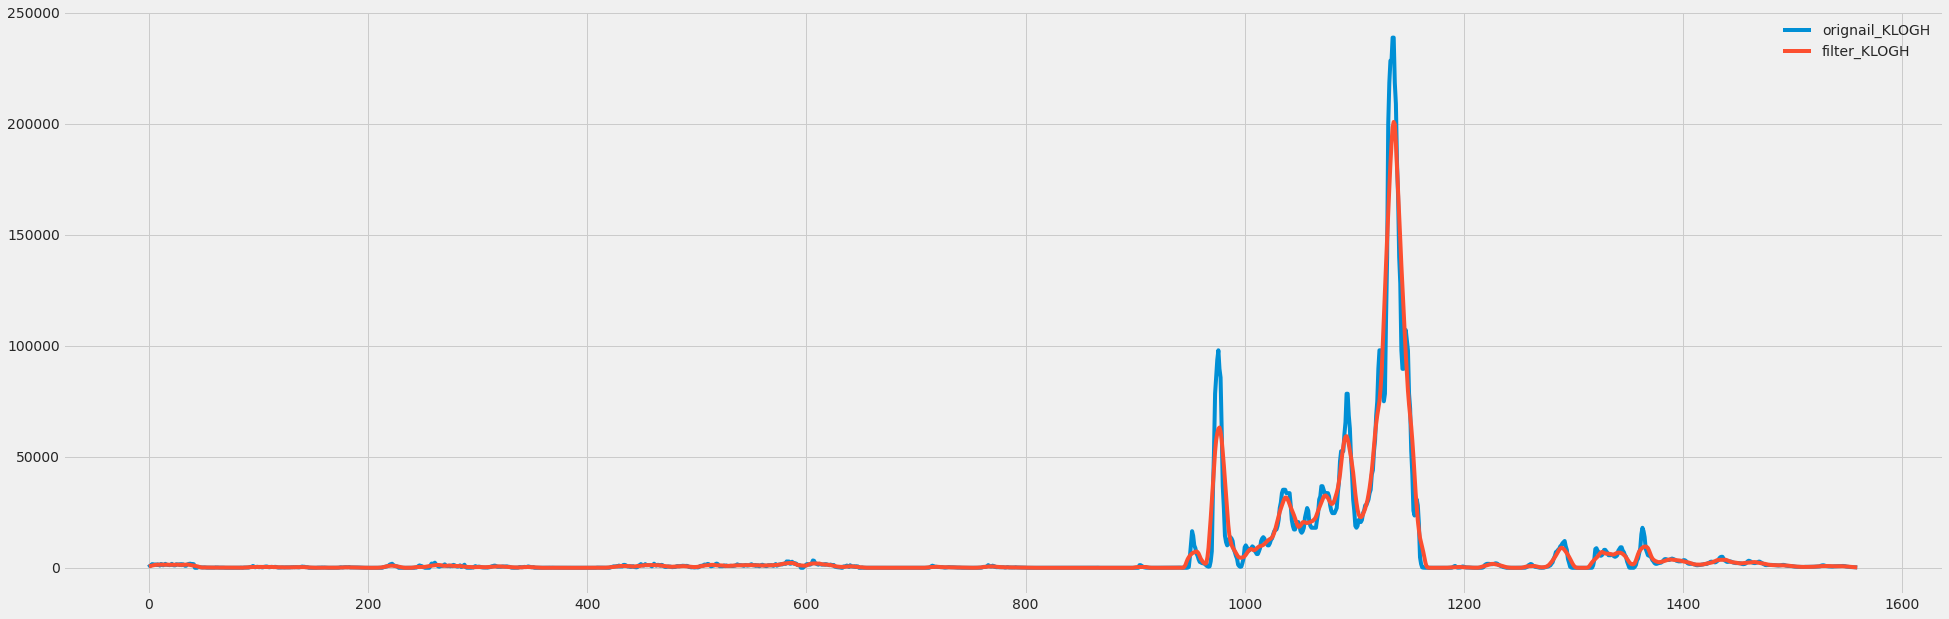

In [ ]:
q = well_train['KLOGH'].values
filter_length = 12
tair_moving_avg1 = np.convolve(q,np.ones((filter_length)),mode = 'same')
tair_moving_avg1 /= filter_length

plt.figure(figsize = (30,10))
plt.plot(q, label = 'orignail_KLOGH')
plt.plot(tair_moving_avg1, label = 'filter_KLOGH')
plt.legend()
plt.show()

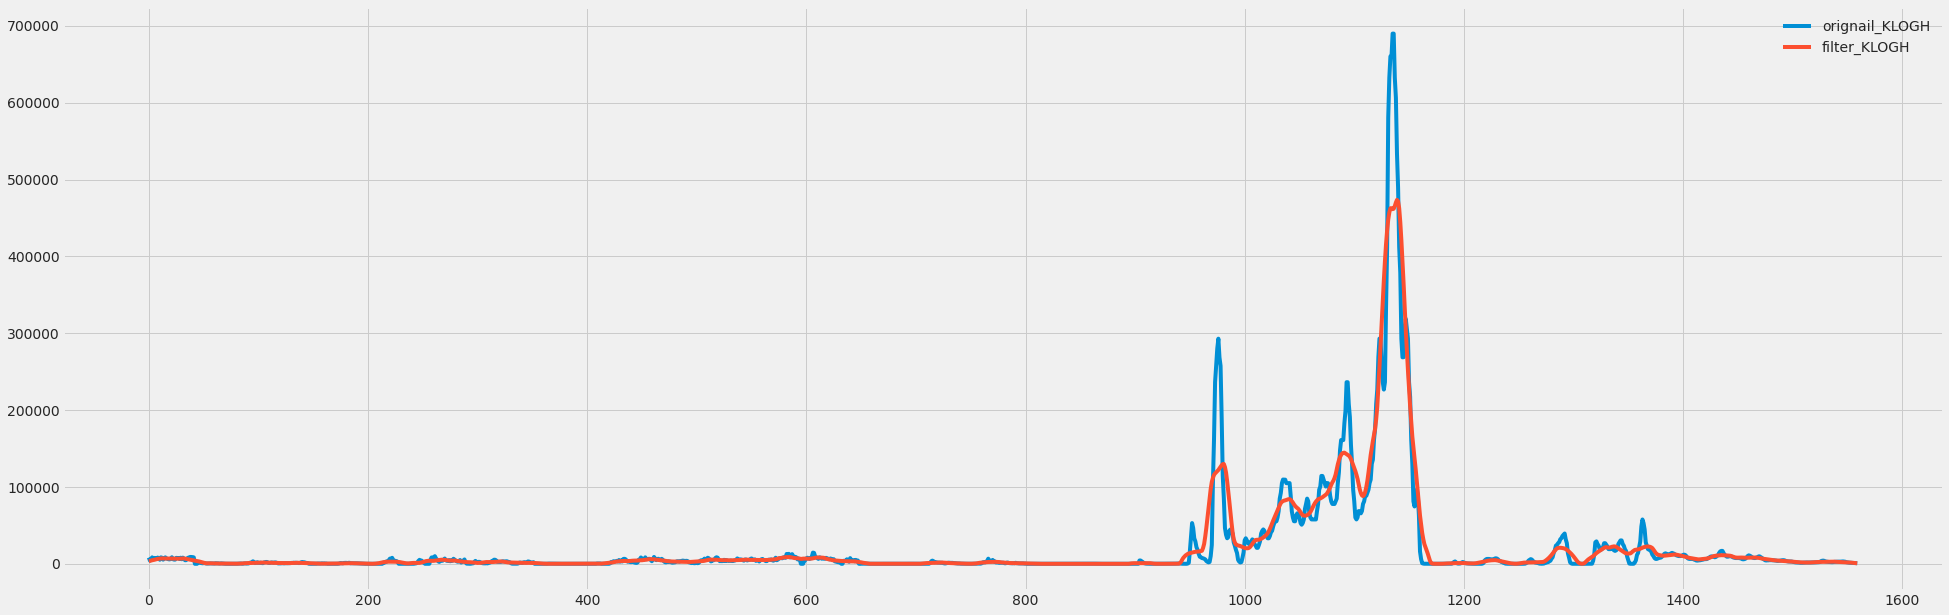

In [ ]:
r = well_train['HMR'].values
filter_length = 20
tair_moving_avg2 = np.convolve(r,np.ones((filter_length)),mode = 'same')
tair_moving_avg2 /= filter_length

plt.figure(figsize = (30,10))
plt.plot(r, label = 'orignail_KLOGH')
plt.plot(tair_moving_avg2, label = 'filter_KLOGH')
plt.legend()
plt.show()

In [ ]:
# Making anotother DataFrame for training dataset


In [ ]:
col = ['S_KLOGH']
kh = pd.DataFrame(tair_moving_avg1, columns=col)

cols = ['S_KLOGV']
kv = pd.DataFrame(tair_moving_avg, columns=cols)

cols = ['S_HMR']
hmr = pd.DataFrame(tair_moving_avg2, columns=cols)

well_train_kvkh = pd.concat([hmr,kh,kv],axis=1)

well_train['KLOGH'] = well_train_kvkh['S_KLOGH'].values
well_train['KLOGV'] = well_train_kvkh['S_KLOGV'].values
well_train['HMR'] = well_train_kvkh['S_HMR'].values

well_train.describe()

PHIF      SW     VSH     BVW       HMR     KLOGH     KLOGV   DEPTH
count 1560.00 1560.00 1560.00 1560.00   1560.00   1560.00   1560.00 1560.00
mean     0.23    0.96    0.28    0.22  19867.10   6321.05   6981.39 3958.34
std      0.06    0.11    0.14    0.06  59303.41  21120.79  25324.28  181.07
min      0.00    0.12    0.02    0.00      1.42      0.01      0.05 3700.12
25%      0.20    0.96    0.12    0.19    676.03     84.67     57.13 3759.52
50%      0.22    1.00    0.37    0.22   2689.55    562.30    496.55 4058.95
75%      0.28    1.00    0.39    0.27   7957.36   1937.73   1730.25 4119.11
max      0.35    1.00    0.90    0.35 473583.23 200802.19 263758.51 4179.72

In [ ]:
wellnames = well_train['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [ ]:
data = {'Logs': ['PHIF',	'SW',	'VSH',	'BVW','HMR','KLOGH',	'KLOGV'],
        'std' : [0.06,	0.14,	0.25,	0.06,	2410.26,	556.69,	536.69],
        'mean': [0.18,	0.94,	0.27,	0.17,	1891.60,	398.04,	354.42]	}
variance_df = pd.DataFrame(data)

variance_df.insert(3,'variance', variance_df['std'].values/variance_df['mean'].values,True)
variance_df

Logs     std    mean  variance
0   PHIF    0.06    0.18      0.33
1     SW    0.14    0.94      0.15
2    VSH    0.25    0.27      0.93
3    BVW    0.06    0.17      0.35
4    HMR 2410.26 1891.60      1.27
5  KLOGH  556.69  398.04      1.40
6  KLOGV  536.69  354.42      1.51

# Step 3. Exploratory Data Analysis

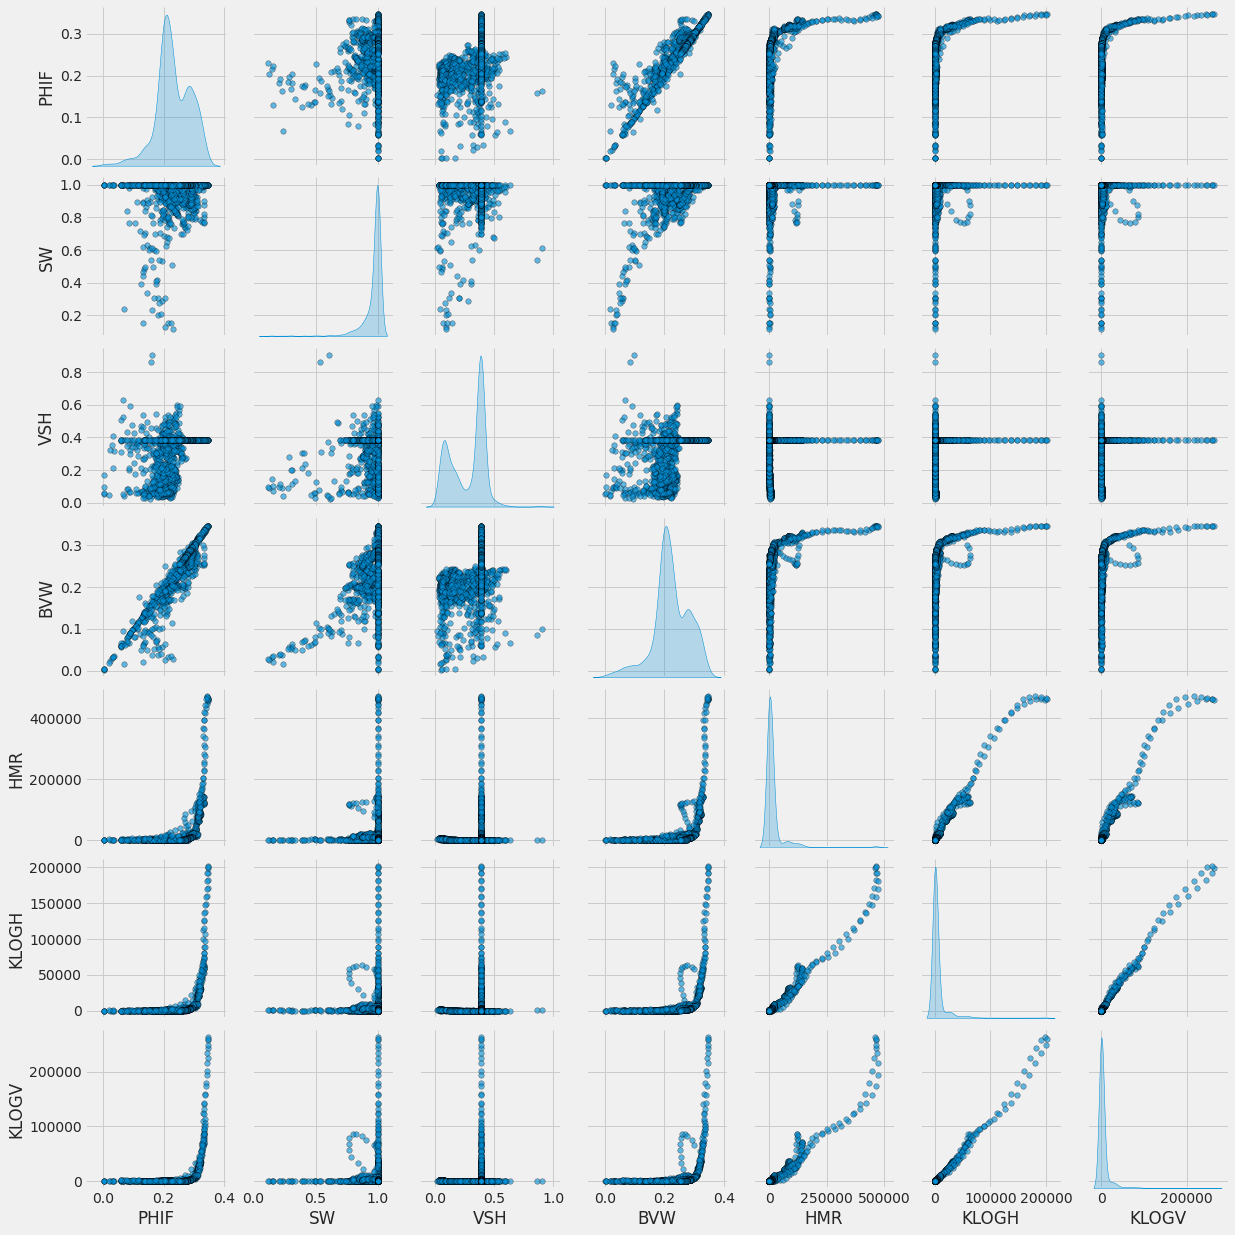

In [ ]:
train_features = ['PHIF','SW','VSH','BVW','HMR','KLOGH', 'KLOGV']

sns.pairplot(well_train, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

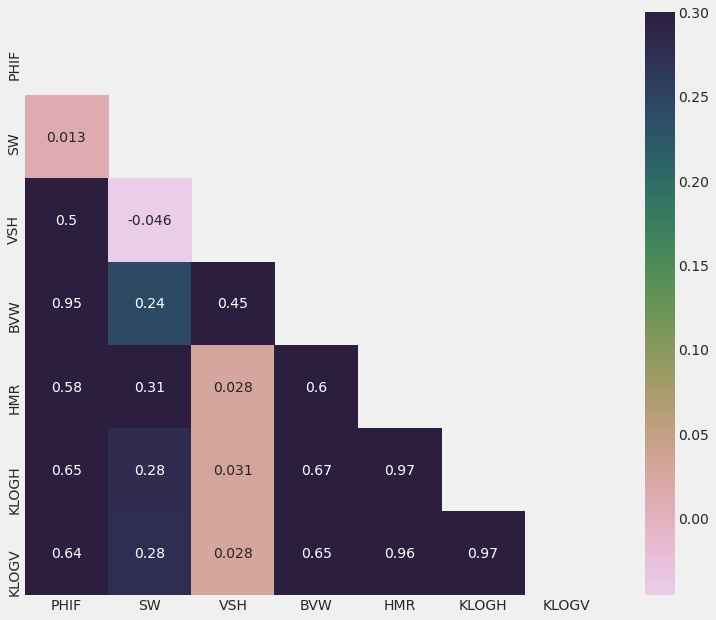

In [ ]:
well_train_only_features = well_train[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

#Step 4. Normalization

In [ ]:
colnames = well_train.columns
only_feature = ['PHIF','SW','VSH','BVW', 'HMR', 'KLOGH'] # only feature column names
only_target = 'KLOGV' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['PHIF', 'SW', 'VSH', 'BVW', 'HMR', 'KLOGH', 'KLOGV', 'WELL', 'DEPTH'], dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
column_drop = ['WELL', 'DEPTH']
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)
well_train_norm

PHIF   SW   VSH   BVW   HMR KLOGH KLOGV         WELL   DEPTH
0    -0.75 0.67 -1.57 -0.58  0.16  0.13  0.18  15_9-19 BT2 4040.12
1    -0.90 0.67 -1.43 -0.72  0.19  0.20  0.26  15_9-19 BT2 4040.28
2    -0.84 0.67 -1.52 -0.66  0.24  0.25  0.32  15_9-19 BT2 4040.43
3    -0.65 0.67 -1.56 -0.48  0.28  0.30  0.36  15_9-19 BT2 4040.58
4    -0.72 0.67 -1.52 -0.55  0.30  0.34  0.41  15_9-19 BT2 4040.73
...    ...  ...   ...   ...   ...   ...   ...          ...     ...
1555  0.41 0.67  0.76  0.57 -0.26 -0.15 -0.17   15_9-19 SR 3799.33
1556  0.40 0.67  0.76  0.54 -0.31 -0.21 -0.23   15_9-19 SR 3799.48
1557  0.36 0.67  0.76  0.52 -0.37 -0.27 -0.29   15_9-19 SR 3799.64
1558  0.35 0.67  0.76  0.49 -0.43 -0.33 -0.36   15_9-19 SR 3799.79
1559  0.32 0.67  0.76  0.48 -0.50 -0.39 -0.44   15_9-19 SR 3799.94

[1560 rows x 9 columns]

In [ ]:
wellnames = well_train_norm['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [ ]:
x = well_train_norm[feature_target].astype(float)
y = well_train_norm['WELL'].astype(str)
z = well_train_norm['DEPTH'].astype(float)

well_train_norm = pd.concat([x, y, z], axis=1)

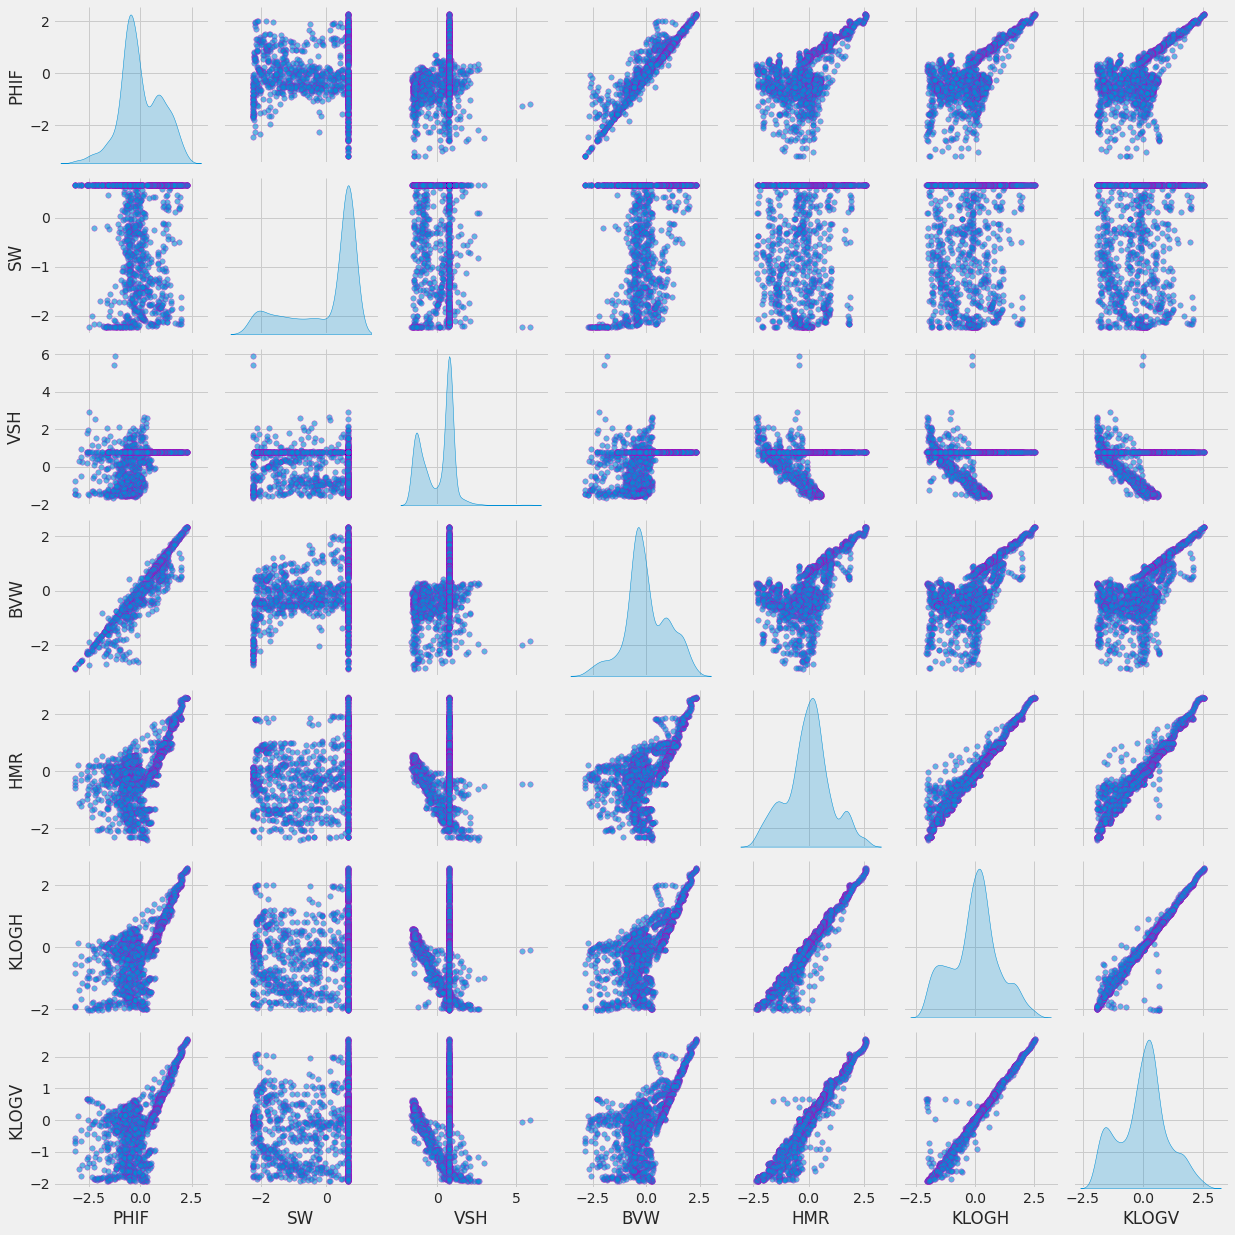

In [ ]:
 x = well_train_norm[feature_target].astype(float)
sns.pairplot(well_train_norm, vars=feature_target, diag_kind = 'kde',
            plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'm'})

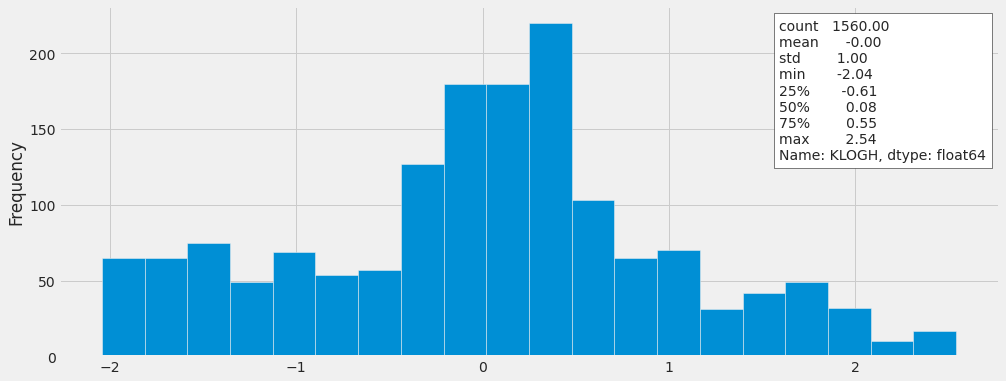

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train_norm['KLOGH'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['KLOGH'].describe()), loc=1)
ax.add_artist(anchored_text)

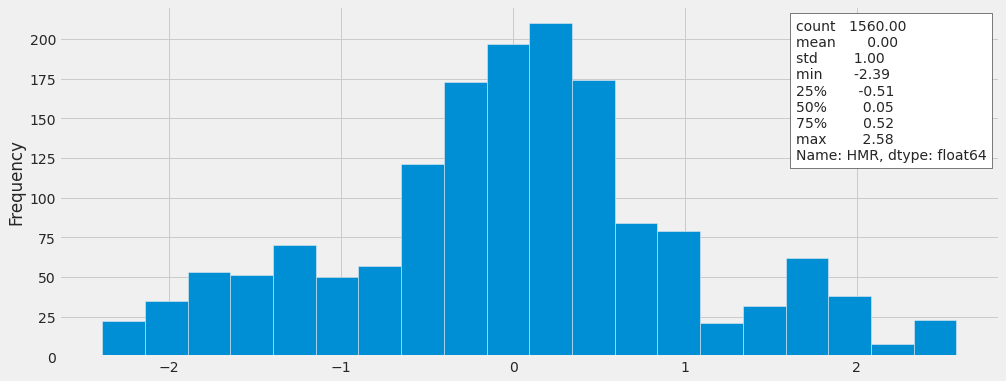

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train_norm['HMR'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['HMR'].describe()), loc=1)
ax.add_artist(anchored_text)

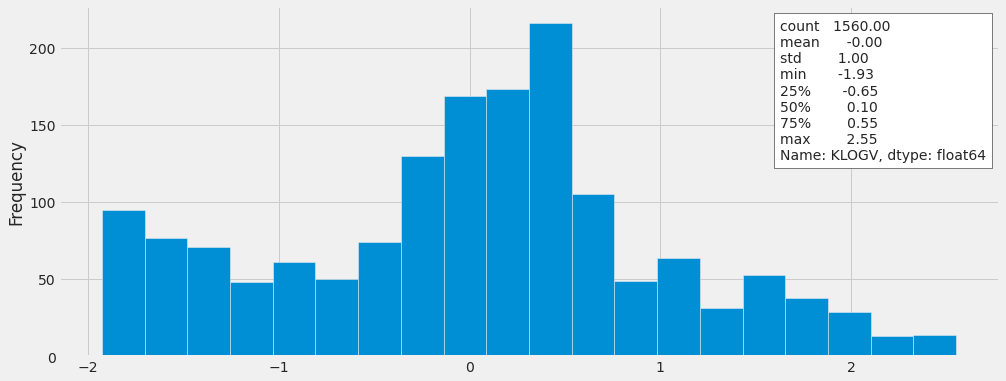

In [ ]:
import plotly.express as px                      ## histrogram of kvlog displayin basis distrinbution 
                                                     ## no usefull as we see go for boxplot
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(15,6))

well_train_norm['KLOGV'].plot.hist(bins=20) #this is the type of plot and which data
anchored_text = AnchoredText(str(well_train_norm['KLOGV'].describe()), loc=1)
ax.add_artist(anchored_text)

In [ ]:
px.box(well_train_norm, x='HMR', orientation='h', points='all')

In [ ]:
px.box(well_train_norm, x='KLOGV', orientation='h', points='all')

In [ ]:
px.box(well_train_norm, x='KLOGH', orientation='h', points='all')

# Step 5. Removing Outliers

In [ ]:
# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# on the well_train_drop, drop WELL and DEPTH column
well_train_drop = well_train_norm.drop(['WELL', 'DEPTH'], axis=1)

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Method 1: Standard Deviation Method (traditional)
well_train_std = well_train_drop[np.abs(well_train_drop - well_train_drop.mean()) <= (3 * well_train_drop.std())]

## delete all rows that have NaNs
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(well_train_drop)
mask = yhat != -1
well_train_iso = well_train_norm[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(well_train_drop)
mask = yhat != -1
well_train_ee = well_train_norm[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(well_train_drop)
mask = yhat != -1
well_train_lof = well_train_norm[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

Number of points before outliers removed                       : 1560
Number of points after outliers removed with Isolation Forest  : 780
Number of points after outliers removed with Outlier Factor    : 1092
Number of points after outliers removed with One-class SVM     : 1405
Number of points after outliers removed with Min. Covariance   : 1404
Number of points after outliers removed with Standard Deviation: 1553


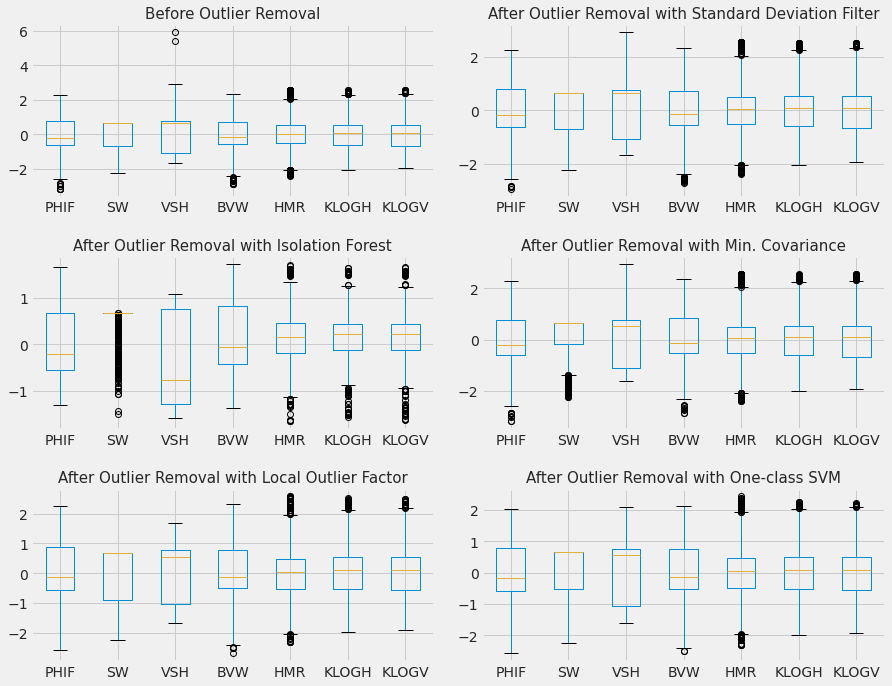

In [ ]:
print('Number of points before outliers removed                       :', len(well_train_norm))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))

plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
well_train_norm[feature_target].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout(1.7)
plt.show()

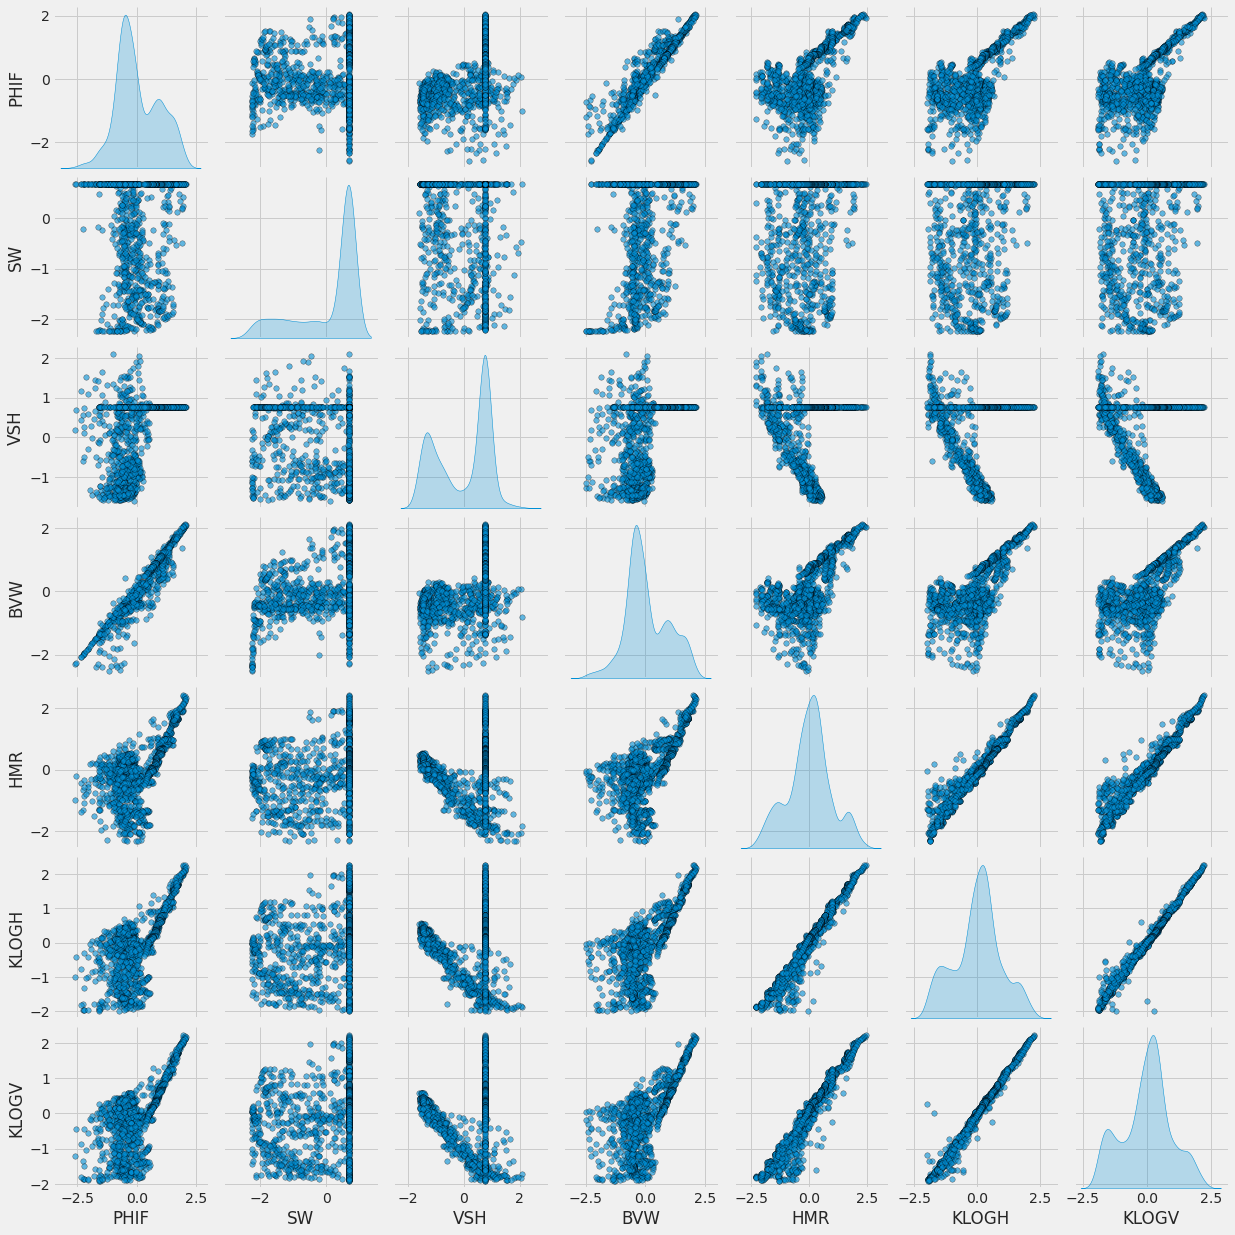

In [ ]:
sns.pairplot(well_train_svm, vars=feature_target,
            diag_kind='kde',
            plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

# Step 6. Prediction! First Attempt

In [ ]:
well_train_svm

PHIF   SW   VSH   BVW   HMR  KLOGH  KLOGV         WELL   DEPTH
0    -0.75 0.67 -1.57 -0.58  0.16   0.13   0.18  15_9-19 BT2 4040.12
1    -0.90 0.67 -1.43 -0.72  0.19   0.20   0.26  15_9-19 BT2 4040.28
2    -0.84 0.67 -1.52 -0.66  0.24   0.25   0.32  15_9-19 BT2 4040.43
3    -0.65 0.67 -1.56 -0.48  0.28   0.30   0.36  15_9-19 BT2 4040.58
4    -0.72 0.67 -1.52 -0.55  0.30   0.34   0.41  15_9-19 BT2 4040.73
...    ...  ...   ...   ...   ...    ...    ...          ...     ...
1555  0.41 0.67  0.76  0.57 -0.26  -0.15  -0.17   15_9-19 SR 3799.33
1556  0.40 0.67  0.76  0.54 -0.31  -0.21  -0.23   15_9-19 SR 3799.48
1557  0.36 0.67  0.76  0.52 -0.37  -0.27  -0.29   15_9-19 SR 3799.64
1558  0.35 0.67  0.76  0.49 -0.43  -0.33  -0.36   15_9-19 SR 3799.79
1559  0.32 0.67  0.76  0.48 -0.50  -0.39  -0.44   15_9-19 SR 3799.94

[1405 rows x 9 columns]

In [ ]:
wellnames = well_train_svm['WELL'].unique()
wellnames

array(['15_9-19 BT2', '15_9-19 SR'], dtype=object)

In [ ]:
# Define the train data
feature = ['PHIF','SW','VSH','BVW', 'HMR','KLOGH']
target = 'KLOGV'

X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values


In [ ]:
# Define the test data 
well_pred1 = well_train_norm.copy()

names_train = ['15_9-19 BT2', '15_9-19 SR']

X_test = []

y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred1.loc[well_pred1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 2 and 3
X_test1, X_test2 = X_test
y_test1, y_test2 = y_test

In [ ]:
X_test2

array([[ 0.78606505,  0.67017134,  0.76412283,  0.8716976 , -0.44465789,
        -0.09619417],
       [ 0.78735033,  0.67017134,  0.76412283,  0.89867373, -0.44443956,
        -0.09226853],
       [ 0.70280468,  0.42373877,  0.76412283,  0.89991598, -0.44412785,
        -0.08986742],
       ...,
       [ 0.36479352,  0.67017134,  0.76412283,  0.52184016, -0.36710159,
        -0.27296541],
       [ 0.3507645 ,  0.67017134,  0.76412283,  0.49217312, -0.42847628,
        -0.33121358],
       [ 0.31515995,  0.67017134,  0.76412283,  0.47865949, -0.49729758,
        -0.39381972]])

R-squared of Well 2: 0.9824365485605266
RMSE of Well 2: 0.100030049550423


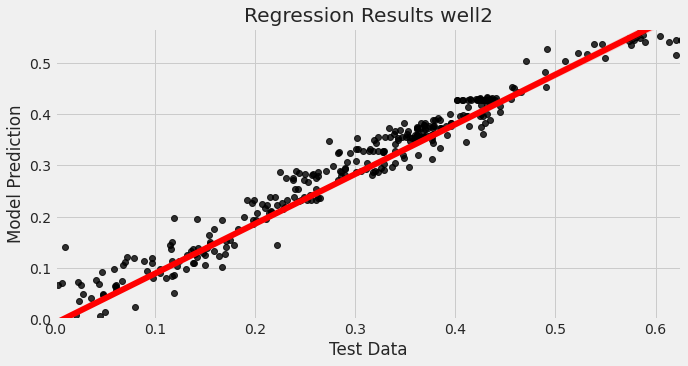

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.9487607224095196
RMSE of Well 3: 0.2220527173909776


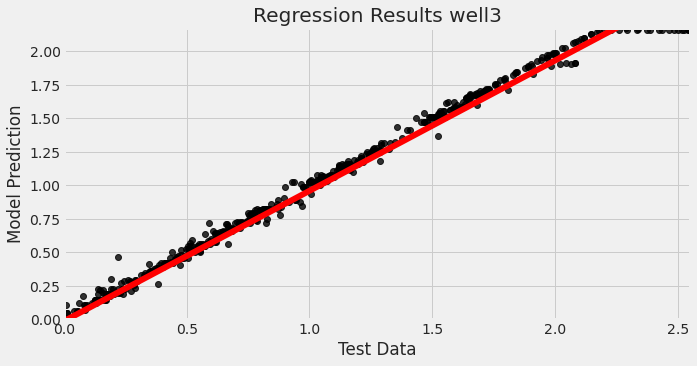

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Create the regressor
model = GradientBoostingRegressor()
# print(model)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Predict on well 2
y_pred1 = model.predict(X_test1)
#reg_metrics(y_test1, y_pred1)
print("R-squared of Well 2: {}".format(model.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = model.predict(X_test2)
print("R-squared of Well 3: {}".format(model.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
     
    plt.show()
reg_plot(y_test2, y_pred2)

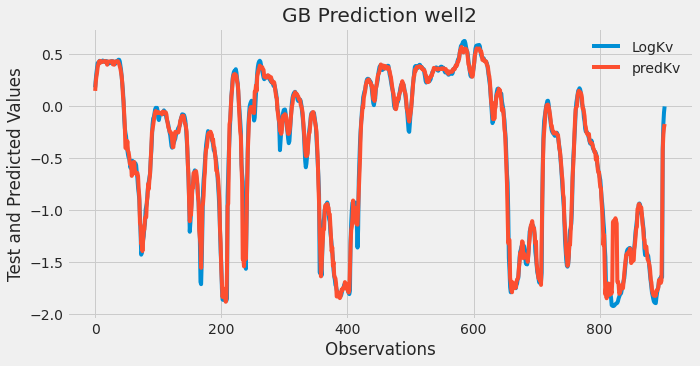

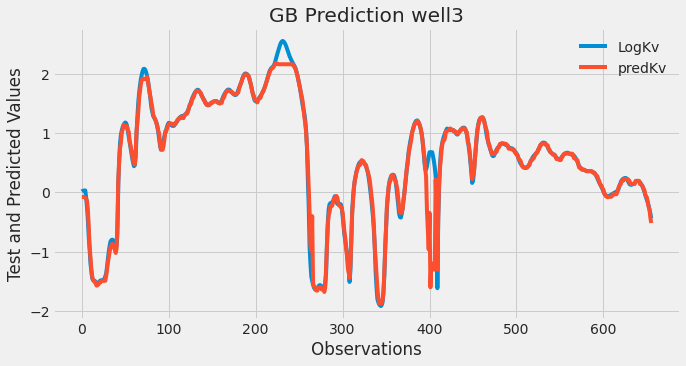

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('GB Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

###########################

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('GB Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

R-squared of Well 2: 0.9831967175206446
RMSE of Well 2: 0.09784139045477327


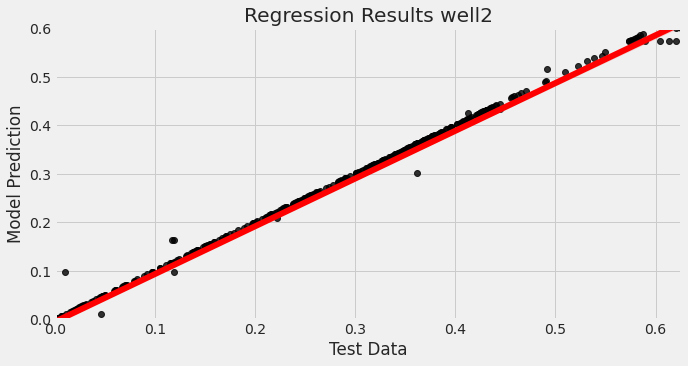

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.9500416425019926
RMSE of Well 3: 0.2192596259772134


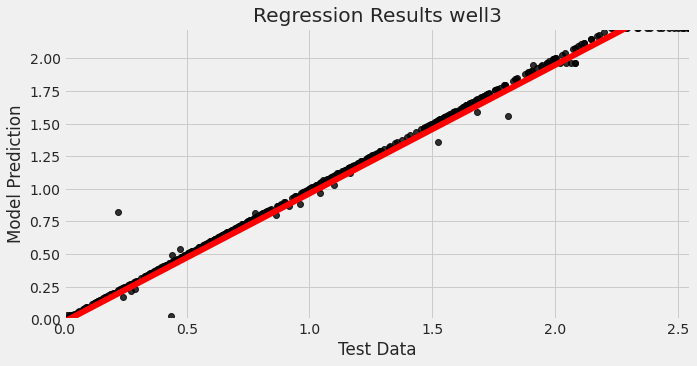

In [ ]:
# 3. Decision Tree - Regression
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
# Prediction on test data
y_pred1 = dt_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(dt_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = dt_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(dt_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2, y_pred2)



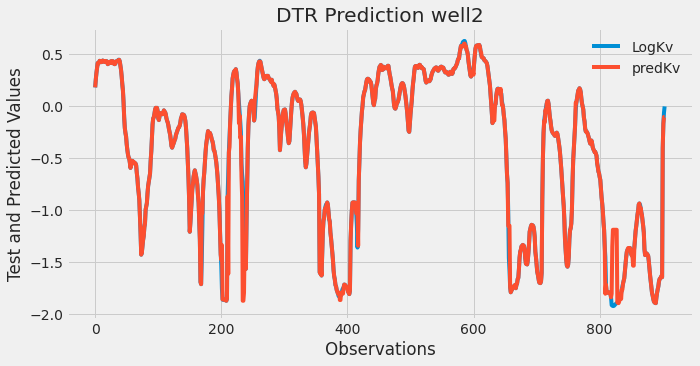

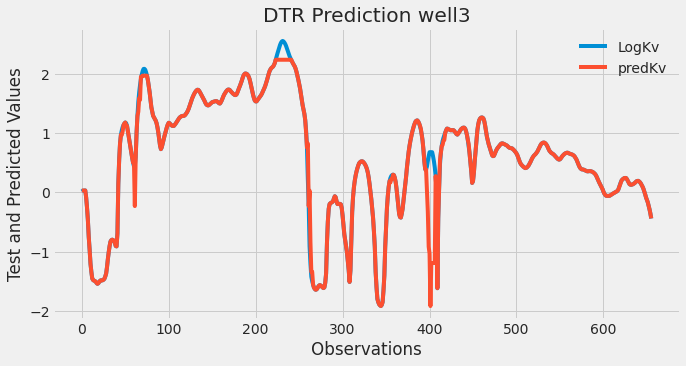

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('DTR Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

#############

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('DTR Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()


-0.017815383204278157
[ 0.26147486  0.04114523 -0.0700089  -0.16601252  0.06887599  0.86093298]
R-squared of Well 2: 0.972356727714139
RMSE of Well 2: 0.12549322423964454


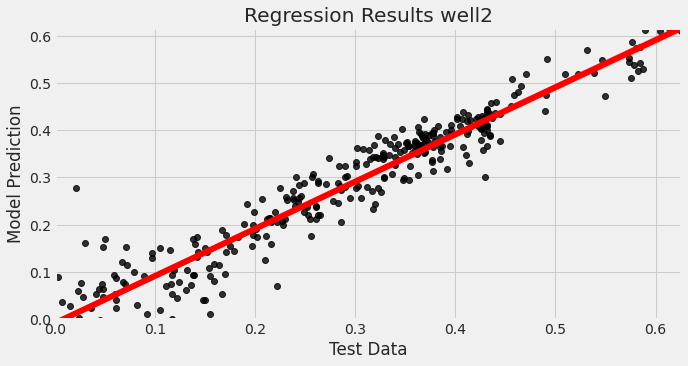

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.894122369474485
RMSE of Well 3: 0.3191954558246645


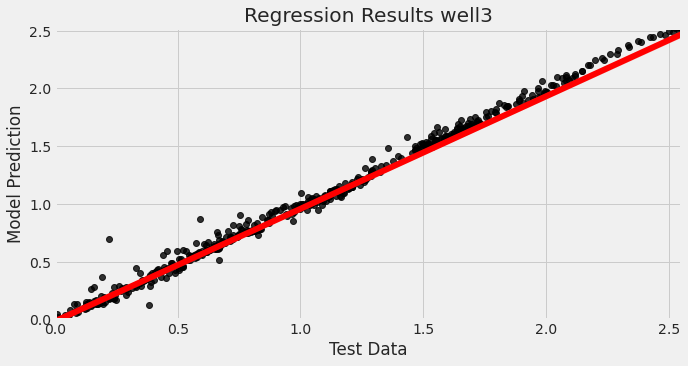

In [ ]:
# 1. MLR - Multi Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)  # training the algorithm
print(lin_reg.intercept_)  # intercept
print(lin_reg.coef_)  # coefficients
# Prediction on test data
y_pred_lin = lin_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(lin_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred_lin))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1,y_pred_lin)
# Predict on well 3
y_pred_lin2 = lin_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(lin_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred_lin2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2,  y_pred_lin2)



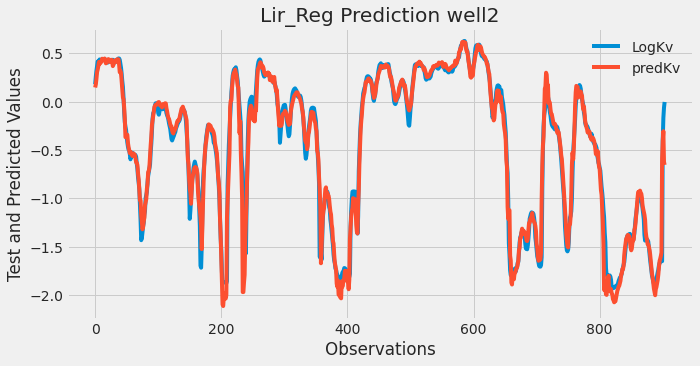

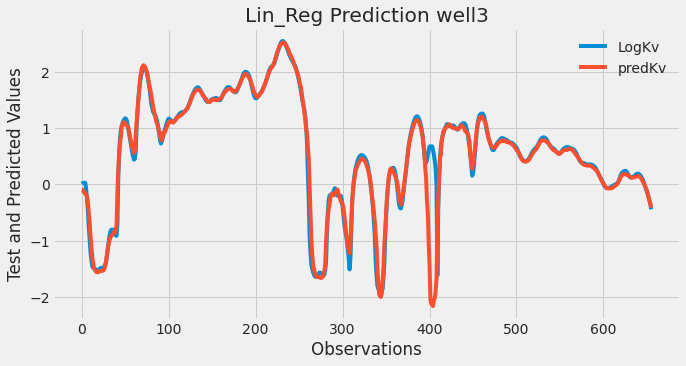

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot( y_pred_lin,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('Lir_Reg Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

########################

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred_lin2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('Lin_Reg Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

R-squared of Well 2: 0.9871484442857361
RMSE of Well 2: 0.08556642816883062


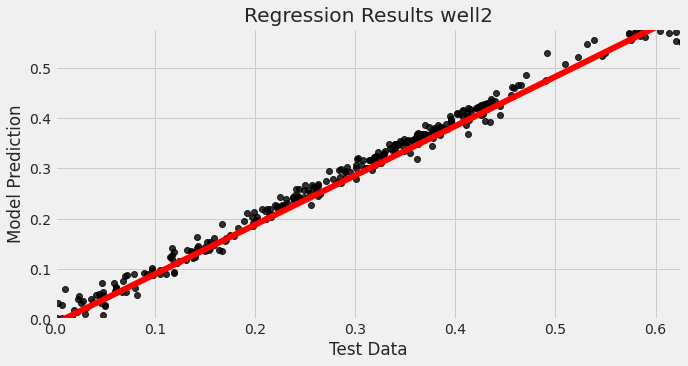

<Figure size 720x360 with 0 Axes>

R-squared of Well 3: 0.945609749556709
RMSE of Well 3: 0.3191954558246645


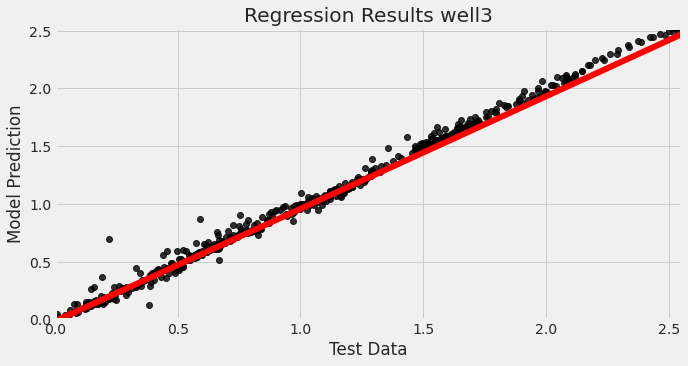

In [ ]:
# 4. Random Forest - Regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
# Prediction on test data
y_pred1 = rf_reg.predict(X_test1)
print("R-squared of Well 2: {}".format(rf_reg.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 2: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well2')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.figure(figsize=(10,5)) 
    plt.show()
reg_plot(y_test1, y_pred1)
# Predict on well 3
y_pred2 = lin_reg.predict(X_test2)
print("R-squared of Well 3: {}".format(rf_reg.score(X_test2, y_test2)))
rmse = np.sqrt(mean_squared_error(y_test2, y_pred2))
print("RMSE of Well 3: {}".format(rmse))
def reg_plot(test, pred):
    plt.figure(figsize=(10,5))
    '''Function returns a regression plot, in the form of a scatter plot'''
    sns.regplot(x=test, y=pred, scatter_kws={
                "color": "black"}, line_kws={"color": "red"})
    plt.xlim(0, max(test))
    plt.ylim(0, max(pred))
    plt.title('Regression Results well3')
    plt.xlabel('Test Data')
    plt.ylabel('Model Prediction')
    plt.show()
reg_plot(y_test2, y_pred2)



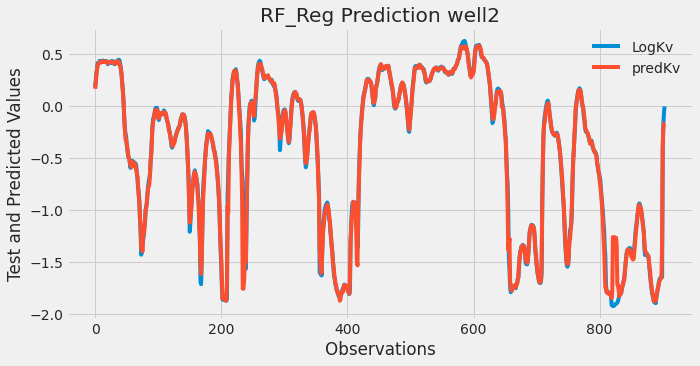

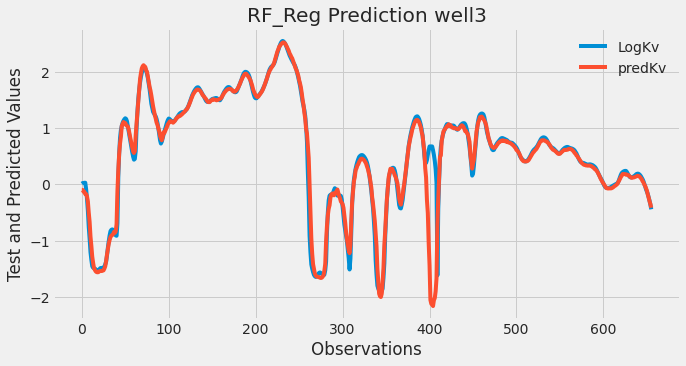

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(y_test1,label = "LogKv")
plt.plot(y_pred1,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('RF_Reg Prediction well2')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

#############

plt.figure(figsize=(10,5)) 
plt.plot(y_test2,label = "LogKv")
plt.plot(y_pred2,label ="predKv")
plt.title("Test and Predicted Values")
plt.title('RF_Reg Prediction well3')
plt.xlabel('Observations')
plt.ylabel('Test and Predicted Values')
plt.legend()

In [ ]:
X = well_train_svm[only_feature].values
y = well_train_svm[only_target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('Shape of Training X:', X_train.shape)
print('Shape of Training y:', y_train.shape)
print('Shape of Test X:', X_test.shape)
print('Shape of Test y:', y_test.shape)

Shape of Training X: (983, 6)
Shape of Training y: (983,)
Shape of Test X: (422, 6)
Shape of Test y: (422,)


In [ ]:
def reg_metrics(test, pred):
    '''Function returns basic metrics for regression models'''
    print('Mean Absolute Error:', metrics.mean_absolute_error(test, pred))
    print('Mean Squared Error:', metrics.mean_squared_error(test, pred))
    print('Root Mean Squared Error:', np.sqrt(
        metrics.mean_squared_error(test, pred)))
    print('R Squared:', (metrics.r2_score(test, pred)))

Epoch 1/20
24/24 [==============================] - 1s 9ms/step - loss: 0.6511 - mse: 0.6511 - val_loss: 0.1583 - val_mse: 0.1583
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0947 - mse: 0.0947 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 8/20
24/24 [==============================] - 0s 4ms/step - loss: 0.0167 - mse: 0.01

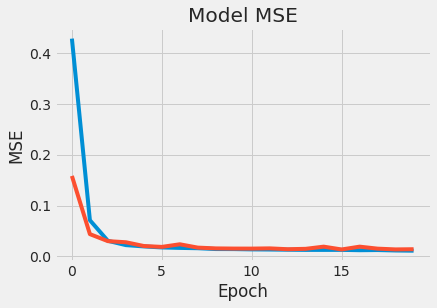

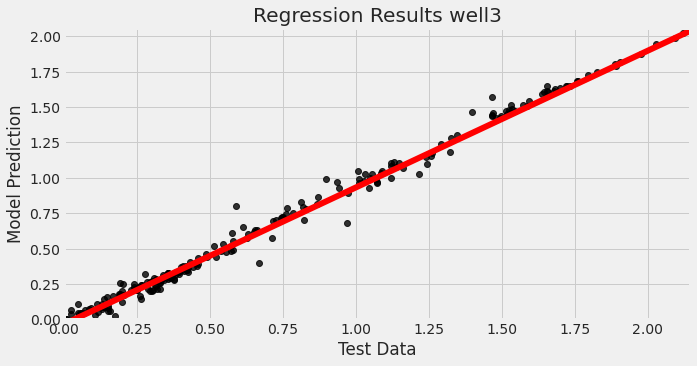

Mean Absolute Error: 0.07196689267570774
Mean Squared Error: 0.017512455640694143
Root Mean Squared Error: 0.13233463507598509
R Squared: 0.9798653584706403


In [ ]:
def build_model():
    ann_reg = keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    ann_reg.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return ann_reg

ann_reg = build_model()
#ann_reg.summary()

history = ann_reg.fit(X_train, y_train, epochs=20, validation_split=0.25, verbose=1)
print(history.history.keys())
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

y_pred_ann = ann_reg.predict(X_test).flatten()
# Regression Plot - ANN
reg_plot(y_test, y_pred_ann)
#scatter_plot_comparison(y_test, y_pred_ann)
# Metrics for ANN
reg_metrics(y_test, y_pred_ann)

In [ ]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test2, y_pred2 = scaler.inverse_transform(y_test2.reshape(-1,1)), scaler.inverse_transform(y_pred2.reshape(-1,1))


In [ ]:

#x = [y_test1, y_pred1, y_test2, y_pred2]
#y = [well2['DEPTH'], well2['DEPTH'], well3['DEPTH'], well3['DEPTH']]

#color = ['purple', 'green', 'purple', 'green']
#title = ['True klog Well 2', 'Predicted klog Well 2', 'True klog Well 3', 'Predicted klog Well 3']
#fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,10))

#for i in range(len(x)):
  #ax[i].plot(x[i], y[i], color=color[i])
 # ax[0].set_xlim(-50, 2200)
  #ax[1].set_xlim(-50, 2200)
 # ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
 # ax[i].set_title(title[i])

#plt.tight_layout(1)

#plt.show()


# Step 7. Decision Trees for Final Prediction

In [ ]:
# Define the X and y from the SVM normalized dataset
X = well_train_svm[only_feature].values
y = well_train_svm[only_target].values

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [10, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

{'max_depth': 10, 'n_estimators': 1000}

In [ ]:
y_pred_ht = model_random.predict(X_test)

print("R-squared: {}".format(rf_reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ht))
print("RMSE: {}".format(rmse))

R-squared: 0.9985903692162109
RMSE: 0.09572501136818604


In [ ]:
well_pred

PHIF   SW  VSH  BVW  KLOGH       WELL   DEPTH
1040  0.14 0.33 0.16 0.05  55.93  15_9-19 A 3825.09
1041  0.15 0.30 0.14 0.05  87.22  15_9-19 A 3825.24
1042  0.16 0.29 0.13 0.04 118.74  15_9-19 A 3825.39
1043  0.16 0.28 0.13 0.04 118.14  15_9-19 A 3825.54
1044  0.16 0.27 0.12 0.04 134.62  15_9-19 A 3825.70
...    ...  ...  ...  ...    ...        ...     ...
1658  0.12 0.52 0.24 0.06   6.87  15_9-19 A 3919.27
1659  0.09 0.69 0.18 0.06  11.51  15_9-19 A 3919.42
1660  0.15 0.48 0.18 0.07  42.22  15_9-19 A 3919.58
1661  0.23 0.36 0.25 0.08  36.27  15_9-19 A 3919.73
1662  0.13 0.56 0.25 0.07   5.17  15_9-19 A 3919.88

[623 rows x 7 columns]

In [ ]:
#well_pred.to_excel('/content/wellpred.xlsx', index=False)
#well_pred = pd.read_excel("/content/sample_data/well_pred.xlsx")

In [ ]:
well_pred.insert(4,'HMR', well_pred['KLOGH'].values/well_pred['PHIF'].values,True)
well_pred.describe()

PHIF     SW    VSH    BVW     HMR   KLOGH   DEPTH
count 623.00 623.00 623.00 623.00  623.00  623.00  623.00
mean    0.19   0.25   0.16   0.04     inf  754.72 3872.48
std     0.05   0.14   0.09   0.01     nan 1448.17   27.43
min     0.00   0.04   0.02   0.00    0.51    0.10 3825.09
25%     0.17   0.18   0.09   0.03  151.04   29.19 3848.79
50%     0.21   0.23   0.17   0.04  572.04  111.23 3872.48
75%     0.23   0.27   0.22   0.05 3291.50  650.68 3896.18
max     0.28   1.00   0.48   0.08     inf 7899.63 3919.88

In [ ]:
# Replacing infinite with nan
well_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
well_pred.dropna(inplace=True)
  
# Printing df
well_pred.describe()

PHIF     SW    VSH    BVW      HMR   KLOGH   DEPTH
count 619.00 619.00 619.00 619.00   619.00  619.00  619.00
mean    0.19   0.24   0.16   0.04  3398.08  759.60 3872.59
std     0.05   0.13   0.09   0.01  6238.12 1451.57   27.48
min     0.00   0.04   0.02   0.00     0.51    0.10 3825.09
25%     0.18   0.18   0.09   0.04   149.42   29.95 3848.63
50%     0.21   0.23   0.17   0.04   571.37  113.42 3872.79
75%     0.23   0.27   0.22   0.05  3194.39  651.70 3896.33
max     0.28   1.00   0.48   0.08 33312.79 7899.63 3919.88

In [ ]:
depth = well_pred['DEPTH'].values
only_feature
well_1 = well_pred[only_feature].values
well_1

array([[1.44541000e-01, 3.27000000e-01, 1.56524000e-01, 4.67570000e-02,
        3.86918591e+02, 5.59256000e+01],
       [1.52656000e-01, 3.01800000e-01, 1.42291000e-01, 4.58230000e-02,
        5.71368960e+02, 8.72229000e+01],
       [1.55366000e-01, 2.87000000e-01, 1.29816000e-01, 4.45030000e-02,
        7.64241855e+02, 1.18737200e+02],
       ...,
       [1.52183000e-01, 4.83500000e-01, 1.76883000e-01, 7.01570000e-02,
        2.77427834e+02, 4.22198000e+01],
       [2.30502000e-01, 3.62400000e-01, 2.53825000e-01, 8.03450000e-02,
        1.57367832e+02, 3.62736000e+01],
       [1.25282000e-01, 5.64500000e-01, 2.54320000e-01, 6.66880000e-02,
        4.12557271e+01, 5.16860000e+00]])

In [ ]:
# Normalize X_test of well 1
well_1 = scaler.fit_transform(well_1)

# Predict to well 1

well1_pred = dt_reg.predict(well_1)

# Denormalize y_pred of well 1
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
well1_pred = scaler.inverse_transform(well1_pred.reshape(-1,1))


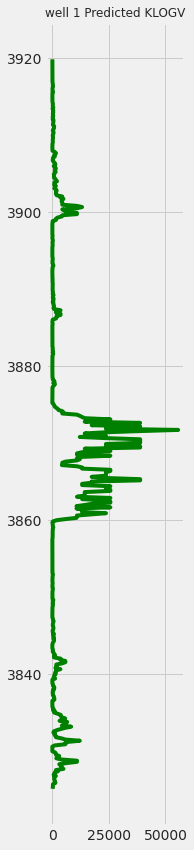

In [ ]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(well1_pred, depth, color='green')
plt.title('well 1 Predicted KLOGV', size=12)
plt.tight_layout(1)
plt.show()

In [ ]:
well_pred['KLOGV'] = well1_pred 
well_pred

PHIF   SW  VSH  BVW    HMR  KLOGH       WELL   DEPTH  KLOGV
1040  0.14 0.33 0.16 0.05 386.92  55.93  15_9-19 A 3825.09 130.60
1041  0.15 0.30 0.14 0.05 571.37  87.22  15_9-19 A 3825.24 192.26
1042  0.16 0.29 0.13 0.04 764.24 118.74  15_9-19 A 3825.39 241.67
1043  0.16 0.28 0.13 0.04 760.35 118.14  15_9-19 A 3825.54 241.67
1044  0.16 0.27 0.12 0.04 863.44 134.62  15_9-19 A 3825.70 271.93
...    ...  ...  ...  ...    ...    ...        ...     ...    ...
1658  0.12 0.52 0.24 0.06  55.20   6.87  15_9-19 A 3919.27   4.23
1659  0.09 0.69 0.18 0.06 128.87  11.51  15_9-19 A 3919.42   1.98
1660  0.15 0.48 0.18 0.07 277.43  42.22  15_9-19 A 3919.58  74.49
1661  0.23 0.36 0.25 0.08 157.37  36.27  15_9-19 A 3919.73  48.55
1662  0.13 0.56 0.25 0.07  41.26   5.17  15_9-19 A 3919.88   7.05

[619 rows x 9 columns]

In [ ]:
c = ['DEPTH'	,'PHIF',	'SW',	'VSH','BVW',	'HMR',	'KLOGH','KLOGV']
final_pred = well_pred[c]
final_pred

DEPTH  PHIF   SW  VSH  BVW    HMR  KLOGH  KLOGV
1040 3825.09  0.14 0.33 0.16 0.05 386.92  55.93 130.60
1041 3825.24  0.15 0.30 0.14 0.05 571.37  87.22 192.26
1042 3825.39  0.16 0.29 0.13 0.04 764.24 118.74 241.67
1043 3825.54  0.16 0.28 0.13 0.04 760.35 118.14 241.67
1044 3825.70  0.16 0.27 0.12 0.04 863.44 134.62 271.93
...      ...   ...  ...  ...  ...    ...    ...    ...
1658 3919.27  0.12 0.52 0.24 0.06  55.20   6.87   4.23
1659 3919.42  0.09 0.69 0.18 0.06 128.87  11.51   1.98
1660 3919.58  0.15 0.48 0.18 0.07 277.43  42.22  74.49
1661 3919.73  0.23 0.36 0.25 0.08 157.37  36.27  48.55
1662 3919.88  0.13 0.56 0.25 0.07  41.26   5.17   7.05

[619 rows x 8 columns]

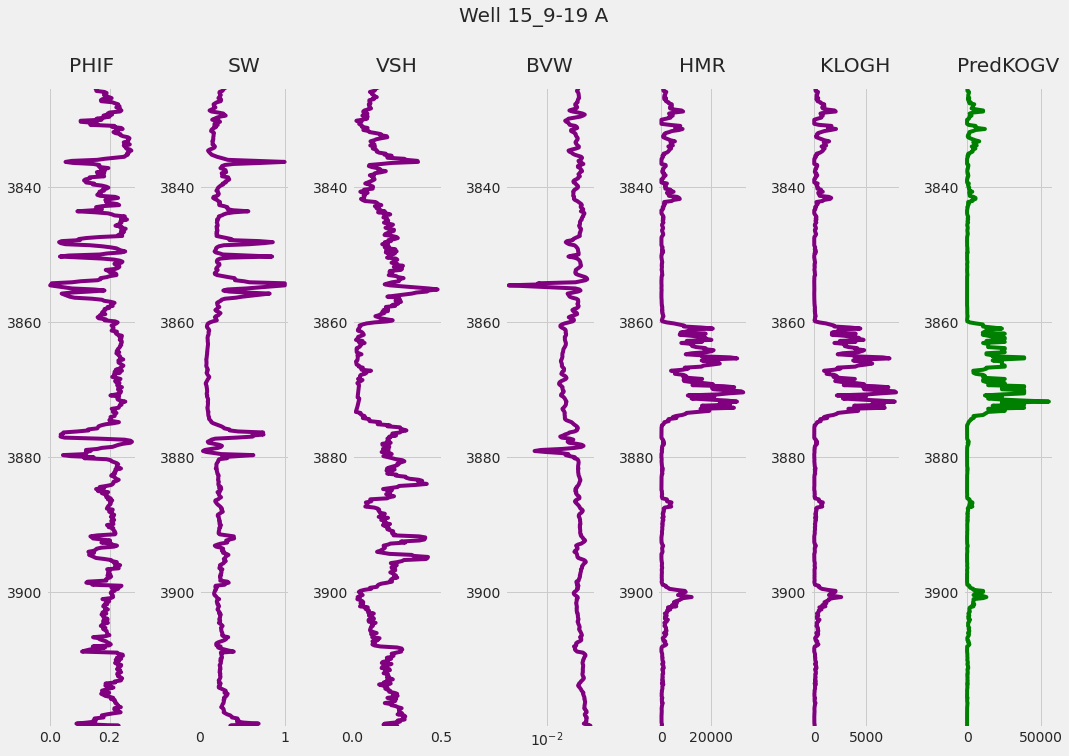

In [ ]:
# Display the test data
well = final_pred
# define what logs are we going to us
logs = ['PHIF','SW','VSH','BVW','HMR', 'KLOGH', 'KLOGV']

# titles to show
title = ['PHIF','SW','VSH','BVW','HMR', 'KLOGH', 'PredKOGV']
# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(15,10))
fig.suptitle('Well 15_9-19 A', size=20, y=1.05)

# looping each log to display in the subplots

colors = ['purple','purple', 'purple', 'purple', 'purple', 'purple', 'green']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_ylim(max(well['DEPTH']), min(well['DEPTH']))
  ax[i].set_title(title[i], pad=15)
  ax[i].grid(True)

#ax[2].set_xlim(0, 200)
plt.tight_layout(1)
plt.show()

In [ ]:
#final_pred.to_csv('/content/FINAL.csv', index=False)

In [ ]:
core_data = pd.read_csv("/content/drive/MyDrive/data/15_9-19A-CORE.csv", na_values=' ')
core_data.head()

DEPTH  OrigDepth  CORE_NO  SAMPLE  CKHG  ...  CPORV    So    Sw  CGD  CGDV
0 3838.60    3837.00        1       1 13.80  ...    nan   nan   nan 2.66   nan
1 3838.85    3837.25        1       2   nan  ...    nan   nan   nan 2.67   nan
2 3839.15    3837.55        1       3 25.20  ...    nan   nan   nan 2.69   nan
3 3839.40    3837.80        1       4  1.02  ...    nan   nan   nan 2.70   nan
4 3839.48    3837.88        1       5   nan  ...  18.80 52.90 36.40  nan  2.68

[5 rows x 14 columns]

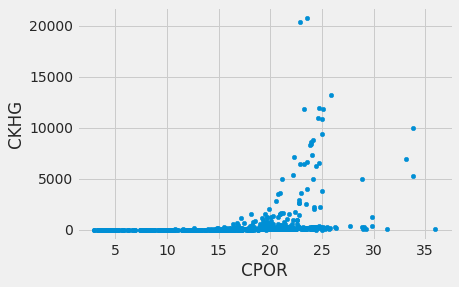

In [ ]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")

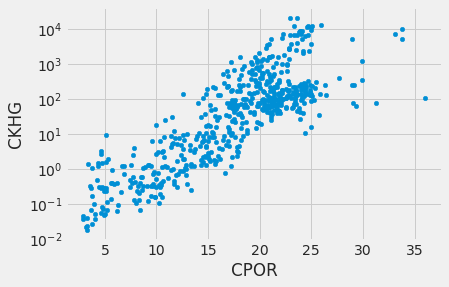

In [ ]:
core_data.plot(kind="scatter", x="CPOR", y="CKHG")
plt.yscale('log')
plt.grid(True)

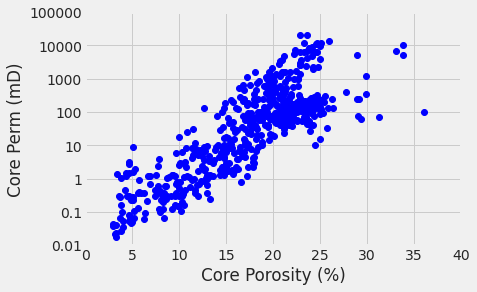

In [ ]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 40, 0.01, 100000])
ax.plot(core_data['CPOR'], core_data['CKHG'], 'bo')
ax.set_yscale('log')
ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)

In [ ]:
##  We can derive a linear regression by using the polyfit function from numpy.
##  As we are working with a semi-log plot, we need to calculate log base 10 of the core permeability.

poro_perm = core_data[['CPOR', 'CKHG']].copy()
poro_perm.dropna(inplace=True)
poro_perm_polyfit = np.polyfit(poro_perm['CPOR'], np.log10(poro_perm['CKHG']), 1)
poro_perm_polyfit

array([ 0.17428705, -1.55607816])

In [ ]:
import statsmodels.api as sm

x = core_data['CPOR']
x = sm.add_constant(x)
y = np.log10(core_data['CKHG'])

model = sm.OLS(y, x, missing='drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CKHG   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1340.
Date:                Sat, 15 May 2021   Prob (F-statistic):          4.26e-150
Time:                        07:50:30   Log-Likelihood:                -601.06
No. Observations:                 557   AIC:                             1206.
Df Residuals:                     555   BIC:                             1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5561      0.088    -17.768      0.000      -1.728      -1.384
CPOR           0.1743      0.005     36.602      0.000       0.165       0.184
==============================================================================
Omnibus:                        6.685   Durbin-Watson:                   0.853
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.790
Skew:                           0.254   Prob(JB):                       0.0335
Kurtosis:                       2.816   Cond. No.                         53.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results.params

const   -1.56
CPOR     0.17
dtype: float64

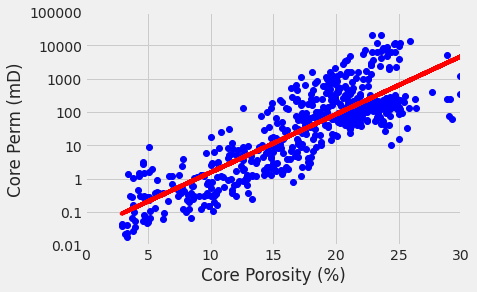

In [ ]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots()

ax.axis([0, 30, 0.01, 100000])
ax.semilogy(core_data['CPOR'], core_data['CKHG'], 'bo')

ax.grid(True)
ax.set_ylabel('Core Perm (mD)')
ax.set_xlabel('Core Porosity (%)')

ax.semilogy(core_data['CPOR'], 10**(results.params[1] * core_data['CPOR'] + results.params[0]), 'r-')


#Format the axes so that they show whole numbers
for axis in [ax.yaxis, ax.xaxis]:
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
    axis.set_major_formatter(formatter)
    
plt.savefig('predicted_poro_perm_xplot.png', dpi=100)


In [ ]:
## Equation of porosity and liquid permeability 
print(results.params[0])
print(results.params[1])
final_pred['PERM']= 10**(results.params[1] * (final_pred['PHIF']*100) + results.params[0])

-1.5560781598525875
0.1742870473595356


In [ ]:
final_pred


DEPTH  PHIF   SW  VSH  BVW    HMR  KLOGH  KLOGV   PERM
1040 3825.09  0.14 0.33 0.16 0.05 386.92  55.93 130.60   9.19
1041 3825.24  0.15 0.30 0.14 0.05 571.37  87.22 192.26  12.72
1042 3825.39  0.16 0.29 0.13 0.04 764.24 118.74 241.67  14.18
1043 3825.54  0.16 0.28 0.13 0.04 760.35 118.14 241.67  14.19
1044 3825.70  0.16 0.27 0.12 0.04 863.44 134.62 271.93  14.50
...      ...   ...  ...  ...  ...    ...    ...    ...    ...
1658 3919.27  0.12 0.52 0.24 0.06  55.20   6.87   4.23   4.10
1659 3919.42  0.09 0.69 0.18 0.06 128.87  11.51   1.98   1.00
1660 3919.58  0.15 0.48 0.18 0.07 277.43  42.22  74.49  12.48
1661 3919.73  0.23 0.36 0.25 0.08 157.37  36.27  48.55 289.25
1662 3919.88  0.13 0.56 0.25 0.07  41.26   5.17   7.05   4.24

[619 rows x 9 columns]

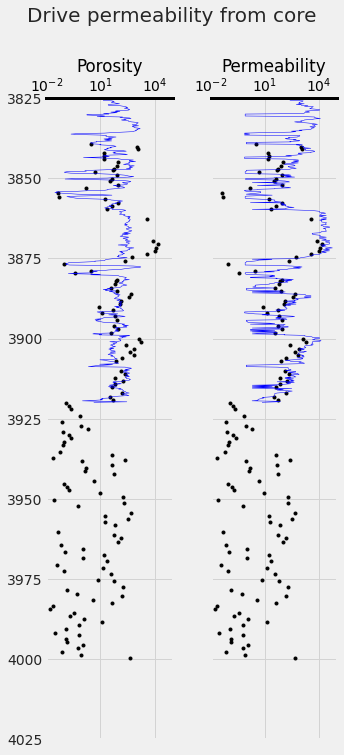

In [ ]:
fig, ax = plt.subplots(figsize=(5,10))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey = ax1)

# Porosity track
ax1.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax1.plot(final_pred['PERM'], final_pred['DEPTH'], color ='blue', linewidth=0.5)
ax1.set_xlabel("Porosity")
ax1.set_xlim(0.1,100000)
ax1.xaxis.label.set_color("black")
ax1.tick_params(axis='x', colors="black")
ax1.spines["top"].set_edgecolor("black")
ax1.set_xticks([0.01, 1, 10, 100, 10000])
ax1.semilogx()
# Permeability track
ax2.plot(core_data["CKVL"], core_data['DEPTH'], color = "black", marker='.', linewidth=0)
ax2.plot(final_pred['KLOGV'], final_pred['DEPTH'], color ='blue', linewidth=0.5)
ax2.set_xlabel("Permeability")
ax2.set_xlim(0.1, 100000)
ax2.xaxis.label.set_color("black")
ax2.tick_params(axis='x', colors="black")
ax2.spines["top"].set_edgecolor("black")
ax2.set_xticks([0.01, 1, 10, 100, 10000])
ax2.semilogx()

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2]:
    ax.set_ylim(4025, 3825)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
# Removes the y axis labels on the second track
for ax in [ax2]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.3)
fig.suptitle('Drive permeability from core', size=20, y=1.05)
plt.savefig('final_track_plot.png', dpi=100)